# Block averaging and statistical analysis

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
        * [Define functions](#sub_section_1_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Signal quality metrics and channel rejection](#section_1_3)
        * [Visual inspection](#sub_section_1_3_1)
        * [Scalp-coupling index](#sub_section_1_3_2)
        * [Peak spectral power](#sub_section_1_3_3)
    * [Motion artefact correction](#section_1_4)
    * [Short channel regression](#section_1_5)
        * [Method of Saager and Berger](#sub_section_1_5_1)
    * [Signal processing methods](#section_1_6)
        * [Bandpass filtering](#sub_section_1_6_1)
* [Post-processing](#chapter_2)
    * [Segmentation and averaging](#section_2_1) 
        * [Extract epochs](#sub_section_2_1_1)
        * [Average epochs](#sub_section_2_1_2)
        * [Topographic representation](#sub_section_2_1_3)
    * [Statistical analysis](#section_2_2) 
        * [Extract data from epochs](#sub_section_2_2_1)
        * [Linear mixed-effect model](#sub_section_2_2_2)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [199]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
import pylab
import pathlib
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne.preprocessing import ICA, corrmap
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr, probplot, kstest, ttest_ind, ttest_rel, shapiro
from scipy.signal import firwin, freqz, filtfilt
from scipy.interpolate import CubicSpline
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from copy import deepcopy
import statsmodels.formula.api as smf
import dataframe_image as dfi
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

#### Define functions <a class="anchor" id="sub_section_1_1_1"></a>

In [2]:
# Write own functions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw


def add_info2(raw_intensity, first_name, last_name, age, sex, EHI):
    """
    Input: raw object, first name, last name, age, sex, EHI
    Function: Returns raw object with added subject info
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')

    return IMU_data, acc_data, gyro_data

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = False
# Export figures?
export = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
raws2 = []
data_dir = pathlib.Path("C:/Users/fabia/fNIRS data analysis/FTT analysis/FTT2/FTT2 data_BIDS")
bids_root = data_dir.with_name(data_dir.name)
for sub in range(1, 5):  # Loop from first to fourth subject
    # Create path to file based on experiment info
    bids_path = BIDSPath(subject="%02d" % sub, task="grasping", datatype="nirs",
                         root=bids_root, suffix="nirs",
                         extension=".snirf")
    raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
raws2

C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))


[<RawSNIRF | sub-01_task-grasping_nirs.snirf, 52 x 6160 (1188.7 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-02_task-grasping_nirs.snirf, 52 x 5900 (1014.6 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-03_task-grasping_nirs.snirf, 52 x 6389 (1149.8 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-04_task-grasping_nirs.snirf, 52 x 6282 (1136.9 s), ~52 kB, data not loaded>]

In [5]:
raw_intensities = []
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
for sub in range(4):
    raw_intensities.append(reorder(raws2[sub]))

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [6]:
raw_intensities[0] = add_info2(raw_intensities[0], 'Subject', '1', 22, 'male', 'right')
raw_intensities[1] = add_info2(raw_intensities[1], 'Subject', '2', 61, 'female', 'right')
raw_intensities[2] = add_info2(raw_intensities[2], 'Subject', '3', 64, 'male', 'right')
raw_intensities[3] = add_info2(raw_intensities[3], 'Subject', '4', 26, 'male', 'right')

In [7]:
# Look at characteristics
sfreqs = []
lowpass = []
for sub in range(4):
    sfreqs.append(raw_intensities[sub].info['sfreq'])
    lowpass.append(raw_intensities[sub].info['lowpass'])
print('Sample frequencies (Hz): ' + str(sfreqs))
print('Max bandwidth (Hz): ' + str(lowpass))

Sample frequencies (Hz): [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039]
Max bandwidth (Hz): [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194]


In [8]:
# Look at segments
events = []
event_dicts = []
for sub in range(4):
    event, event_dict = mne.events_from_annotations(raw_intensities[sub])
    events.append(event)
    event_dicts.append(event_dict)
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 21))

mne.viz.plot_events(events[0], event_id=event_dicts[0], sfreq=raw_intensities[0].info['sfreq'], axes=axes[0,0], show = False)
mne.viz.plot_events(events[1], event_id=event_dicts[1], sfreq=raw_intensities[1].info['sfreq'], axes=axes[0,1], show = False)
mne.viz.plot_events(events[2], event_id=event_dicts[2], sfreq=raw_intensities[2].info['sfreq'], axes=axes[1,0], show = False)
mne.viz.plot_events(events[3], event_id=event_dicts[3], sfreq=raw_intensities[3].info['sfreq'], axes=axes[1,1], show = False)
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

fig.show()

Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']


---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- Different sample frequencies are used for each participant = [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039] Hz
- LPF = [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194] Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
---

##### Resample data

In [9]:
f_min = np.min(sfreqs)
for sub in range(4):
    raw_intensities[sub].resample(f_min)

Sampling frequency of the instance is already 5.181347150259067, returning unmodified.


---
> *Remark:*
- Sample frequencies are downsampled to lowest sample frequency of the 4 subjects
- Sample frequency: 5.18 Hz
- LPF = 2.59 Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
---

##### Validate that the location of sources-detector pairs and channels are in the expected locations

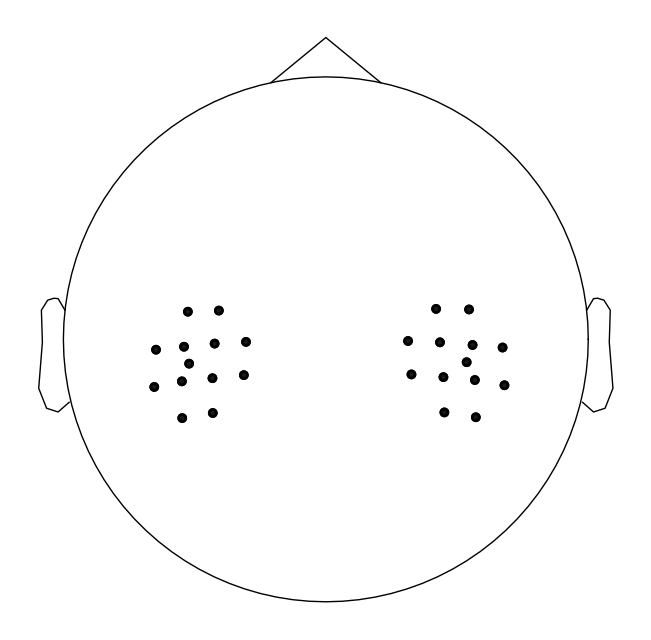

In [10]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensities[0].plot_sensors();

In [11]:
sns.set_theme()

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

### Signal quality metrics and channel rejection <a class="anchor" id="section_1_3"></a>

#### Visual inspection <a class="anchor" id="sub_section_1_3_1"></a>

The quality of a fNIRS recording can be assessed by a visual inspection of the signals. On the one hand there can be features present in the signals which indicate a good signal quality, such as certain physiological components, and on the other hand there can be features present which indicate bad signal quality in one or more channels, such as MAs.

##### Visual inspection of the raw light intensity data

###### Subject 1 

In [12]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [13]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [14]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [15]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[3].plot(duration=300, show_scrollbars = True, clipping = None);

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [16]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_ods = []
for sub in range(4):
    raw_ods.append(optical_density(raw_intensities[sub]))

Reading 0 ... 6159  =      0.000 ...  1188.687 secs...


###### Subject 1

In [17]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[0].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 2

In [18]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[1].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 3

In [19]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[2].plot(duration=300, show_scrollbars = True, clipping = None);

###### Subject 4

In [20]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[3].plot(duration=300, show_scrollbars = True, clipping = None);

---
> *Remark:*
- For more information about the visual inspection procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

##### Separate long and short channels

The short channels were not assessed using signal quality metrics because they inherently contain physiological noise. These channels cannot be removed from the dataset as they are essential for performing short channel regression.


In [21]:
raw_ods_full = []
raw_ods_short = []
raw_ods_new = []
min_dist = 0.01 
max_dist = 0.045
for sub in range(4):
    raw_ods_full.append(raw_ods[sub].copy())
    raw_ods_short.append(get_short_channels(raw_ods[sub], max_dist=min_dist))
    raw_ods_new.append(get_long_channels(raw_ods[sub], min_dist=min_dist, max_dist=max_dist))

In [22]:
raw_ods = raw_ods_new

In [23]:
# Short channels are: (channel number 16 and 17)
raw_ods_full[0].ch_names[32:36]

['S9_D1 760', 'S9_D1 850', 'S10_D2 760', 'S10_D2 850']

#### Scalp-coupling index <a class="anchor" id="sub_section_1_3_2"></a>

The SCI is a quality measurement of the connection between the optodes and the scalp of the participant using the strong cardiac oscillation in raw fNIRS signals. With a sufficiently high sampling rate (e.g.: 10 Hz), the heartbeat emerges as a dependable marker for evaluating optode-scalp coupling. It was first introduced by Pollonini et al. (2013) and it assesses the synchronous cardiac pulsation in the two photodetected signals (760 and 850 nm) in the cardiac band (0.5 - 2.5 Hz). After the bandpass-filtering the resulting signals are normalized to balance any difference between their amplitude. Finally, the zero-lag cross-correlation between photodetected signals of the same channel is used as a quantitative measure of the SNR of that specific channel. A threshold of SCI $>$ 0.75 is recommended by the authors.

Given that the frequency band of 0.5 - 2.5 Hz is quite broad and the participants are relatively at rest while seated, a FIR filter with a narrower band of 0.7 - 1.5 Hz is applied (40 bpm - 85 bpm). The transition band width at both the low and high cut-off frequencies is set to 0.3 Hz.

##### SCI evaluated over complete signal

In [24]:
# Calculate SCI with build-in function of mne_nirs
scis = []
for sub in range(4):
    scis.append(scalp_coupling_index(raw_ods[sub], l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False))
    # SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

In [25]:
# Copy raw object to apply SCI 
raw_od_SCIs = []
for sub in range(4):
    raw_od_SCIs.append(raw_ods[sub].copy())
# Mark channels with SCI < 0.75 as BAD
for sub in range(4):
    raw_od_SCIs[sub].info['bads'] = list(compress(raw_ods[sub].ch_names, scis[sub] < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
    print('The ' + str(len(raw_od_SCIs[sub].info['bads'])) + ' bad channels for subject ' + str(sub+1) + ' are: ' + str(raw_od_SCIs[sub].info['bads']))

The 14 bad channels for subject 1 are: ['S3_D1 760', 'S3_D1 850', 'S7_D1 760', 'S7_D1 850', 'S6_D4 760', 'S6_D4 850', 'S7_D3 760', 'S7_D3 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S7_D9 760', 'S7_D9 850']
The 16 bad channels for subject 2 are: ['S2_D2 760', 'S2_D2 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']
The 0 bad channels for subject 3 are: []
The 20 bad channels for subject 4 are: ['S1_D1 760', 'S1_D1 850', 'S3_D1 760', 'S3_D1 850', 'S5_D1 760', 'S5_D1 850', 'S7_D1 760', 'S7_D1 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']


##### SCI evaluated over moving window

Some extra channels are marked bad due to consistent bad scores over time (see **Signal quality metrics and channel rejection - FTT 2** Notebook).

In [26]:
# Add bad channels
raw_od_SCIs[2].info['bads'] += ['S6_D6 760', 'S6_D6 850']
raw_od_SCIs[3].info['bads'] += ['S2_D2 760', 'S2_D2 850']

---
> *Remark:*
- For more information about the scalp-oupling index procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

#### Peak spectral power <a class="anchor" id="sub_section_1_3_3"></a>

Pollonini et al. (2016) state that to enhance the reliability of a quantitative measure for scalp coupling, the spectral power of the cross-correlated signal can serve as an additional indicator of cardiac signal strength. By setting a spectral power threshold, it becomes possible to objectively differentiate between a clear optical channel and a noisy one. Theoretically, photodetected cardiac signals can be conceptualized as two sinusoidal waves oscillating at the physiological frequency $f_{cardiac}$ (e.g.: 1 Hz or 60 bpm) with arbitrary amplitude and offset. The resultant normalized cross-correlation signal ($\overline{x_{\lambda_1}}  \otimes \overline{x_{\lambda_2}}$) exhibits unity amplitude, a frequency of $f_{cardiac}$ and a peak power of 0.5. Therefore, a threshold can be established at a certain fraction of the ideal peak power. However, in practice, cardiac photoplethysmographic signals are not strictly sinusoidal and may contain quantization noise, which reduces the peak power value. Hence, the authors recommend empirically setting the threshold value at 0.1.

In [27]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSPs = []
for sub in range(4):
    raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCIs[sub], time_window=10)
    raw_od_SCI_PSPs.append(raw_od_SCI_PSP)

---
> *Remark:*
- For more information about the peak spectral power procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

---
> *Remark:*
- Some time segments are marked manually as bad
- Selection of channels marked as bad through SCI
- Peak spectral power marked time segments in selected channels bad
---

### Motion artefact correction <a class="anchor" id="section_1_4"></a>

#### Temporal derivative distribution repair <a class="anchor" id="sub_section_1_4_1">

The TDDR method was introduced by Fishburn et al. in 2019. It offers both online and offline filtering approaches based on the temporal derivative of fNIRS signals, requiring no user-defined parameters. Moreover, it is applicable to concentration changes, optical intensities, and optical densities (Huang et al., 2022).

This method operates under specific assumptions: (1) non-motion-related fluctuations follow a normal distribution, (2) the majority of fluctuations are unrelated to motion artifacts, and (3) MA derivatives dominate in the derivatives of fNIRS signals during their presence.

The algorithm comprises five distinct steps. Fishburn et al. (2019) provides an in-depth description of each step.

##### Perform TDDR on OD data

In [28]:
# Add short channels again
for sub in range(4):
    raw_od_SCIs[sub].add_channels([raw_ods_short[sub]])

In [29]:
raw_ods_TDDR = []
for sub in range(4):
    raw_ods_TDDR.append(temporal_derivative_distribution_repair(raw_od_SCIs[sub]))

### Short channel regression <a class="anchor" id="section_1_5"></a>

The reflectance measurements at two detectors, L and S, allow for the calculation of absorbance changes $\Delta A_L (t)$ and $\Delta A_S (t)$. To eliminate the influence of the superficial component of the probed tissue, measurements can be taken using two SDD: long and short. This can be achieved using the equation:
$$ \Delta A_C (\lambda, t) = \Delta A_L (\lambda, t) - \alpha \cdot \Delta A_S (\lambda, t)$$

Here, $\Delta A_C (\lambda, t)$ represents the corrected attenuation, $\Delta A_L (\lambda, t)$ corresponds to the attenuation at the long SDD (sampling both brain and superficial components), and $\Delta A_S (\lambda, t)$ pertains to the short SDD (sampling only superficial components) (Scholkmann et al., 2014). 

According to Saager and Berger (2005), the scaling parameter $\alpha$ can be determined directly using a least-squares method:

$$\alpha = \frac{\Delta A_S (\lambda, t) \cdot \Delta A_L (\lambda, t)}{\Delta A_S (\lambda, t) \cdot \Delta A_S (\lambda, t)}$$


In [30]:
# Short channels predominantly contain systemic responses and long channels have both neural and systemic contribution
raw_ods_SCR = []
for sub in range(4):
    raw_ods_SCR.append(short_channel_regression(raw_ods_TDDR[sub].copy(), max_dist=min_dist))

### Signal processing methods <a class="anchor" id="section_1_6"></a>

#### Bandpass filtering <a class="anchor" id="sub_section_1_6_1"></a>

Bandpass filtering is a common technique used in fNIRS research to remove both high-frequency components, such as instrument noise and cardiac pulsations, and low-frequency components from the signal. The filter characteristics significantly influence the filtered data, so it is crucial to specify the type of filtering applied, the filter order, and the cutoff frequencies (Yucel et al., 2021). 

When choosing the filter type, considering the phase response is important, as filters with a nonlinear phase response can distort the signal or cause phase shifts across the frequency band. Finite impulse response (FIR) filters, which have linear phase responses, can be safely applied both offline and online (during data collection). In contrast, infinite impulse response (IIR) filters (e.g.: Butterworth) require zero-phase correction, necessitating the entire signal at once, and therefore can only be applied offline. Additionally, FIR filters are more stable and easier to control than IIR filters, ensuring that the output remains finite (Yucel et al., 2021).

Following the guidelines of Pinti et al. (2019), a FIR bandpass filter with order 1000, low cut-off frequency $F_{c, low} = 0.01 Hz$ and a high cut-off frequency $f_{experiment} < f_{c, high} < f_{Mayer-wave}$ will be performed on the haemodynamic data.

##### Convert OD data to haemodynamic data

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [31]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemos_short = []
raw_haemos = []
for sub in range(4):
    raw_haemo = beer_lambert_law(raw_ods_SCR[sub], ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.
    raw_haemos_short.append(get_short_channels(raw_haemo, max_dist=min_dist)) 
    raw_haemos.append(get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist))

##### Plot filter response

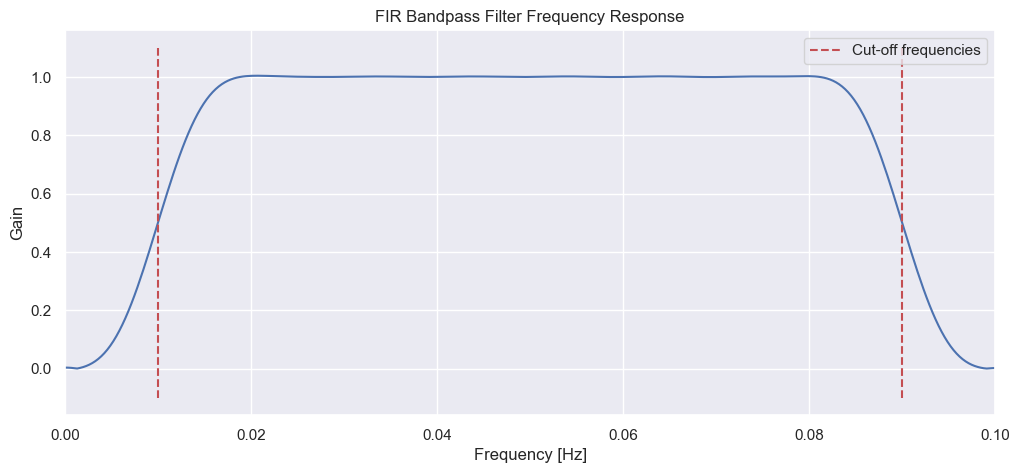

In [32]:
# Specifications
order = 1000
sample_rate = raw_haemos[0].info['sfreq']  # Example sample rate in Hz
nyquist_rate = sample_rate / 2.0
cutoff_freqs = [0.01, 0.09]  # Cut-off frequencies in Hz

# Normalize the cut-off frequencies to Nyquist frequency
normalized_cutoff = [f / nyquist_rate for f in cutoff_freqs]

# Design the FIR bandpass filter using firwin
fir_coefficients = firwin(order + 1, normalized_cutoff, pass_zero='bandpass')

# Plot the frequency response
w, h = freqz(fir_coefficients, worN=8000)
plt.figure(figsize=(12,5))
plt.plot(0.5 * sample_rate * w / np.pi, np.abs(h), 'b')
plt.title('FIR Bandpass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
#plt.xscale('log')
plt.ylabel('Gain')
plt.xlim((0,0.1))
plt.vlines(cutoff_freqs, -0.1, 1.1, linestyle = '--', color = 'r',  label = 'Cut-off frequencies')
plt.legend()
if export:
    plt.savefig('FIR_BPF_response_FTT2.png')
plt.show()

##### Define BPF

In [33]:
def BPF(raw_input, fir_coefficients, sample_rate, plot = False, export = False, filename = None):

    raw_ = raw_input.copy()
    data = raw_.get_data()
    picks = np.sort(_validate_nirs_info(raw_.info))

    for pick in picks:
        signal = data[pick]
        filtered_signal = filtfilt(fir_coefficients, 1.0, signal) # Zero phase filtering (Can only be done offline)
        
        raw_._data[pick] = filtered_signal
    
    if plot:
        compare_original_filtered(raw_, raw_input, export = export, filename = filename)
    
    return raw_

##### Perform BPF

In [34]:
raw_haemos_filtered = []
for sub in range(4):
    raw_haemos_filtered.append(BPF(raw_haemos[sub], fir_coefficients, sample_rate, plot = plot, export = export, filename = 'BPF/FTT2_BPF_subject_' + str(sub+1)))

##### Compare PSD before and after filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);


Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 395.264 (s)
Plotting power spectral density (dB=True).


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1215430090.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);


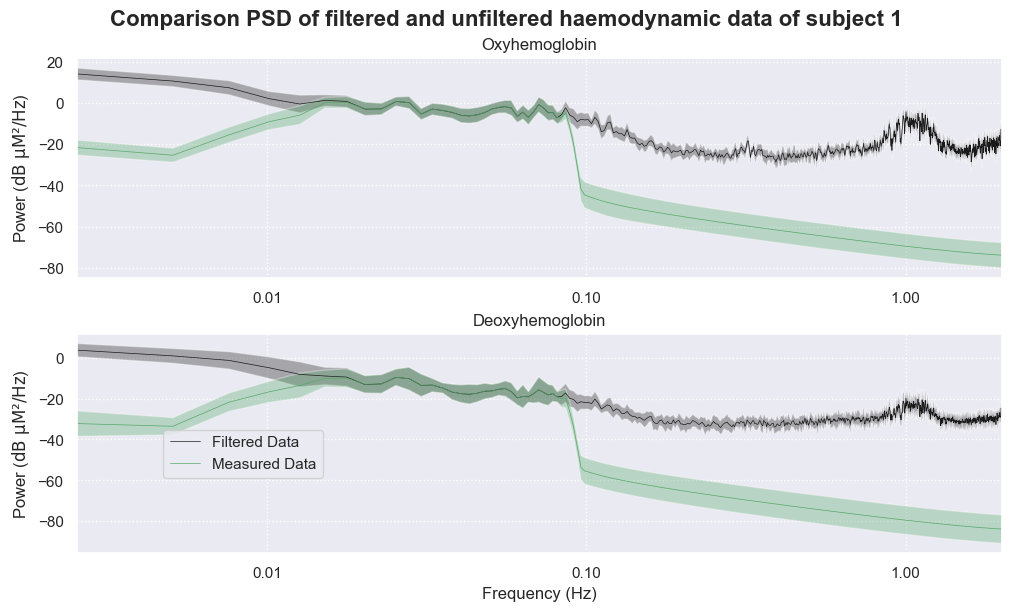

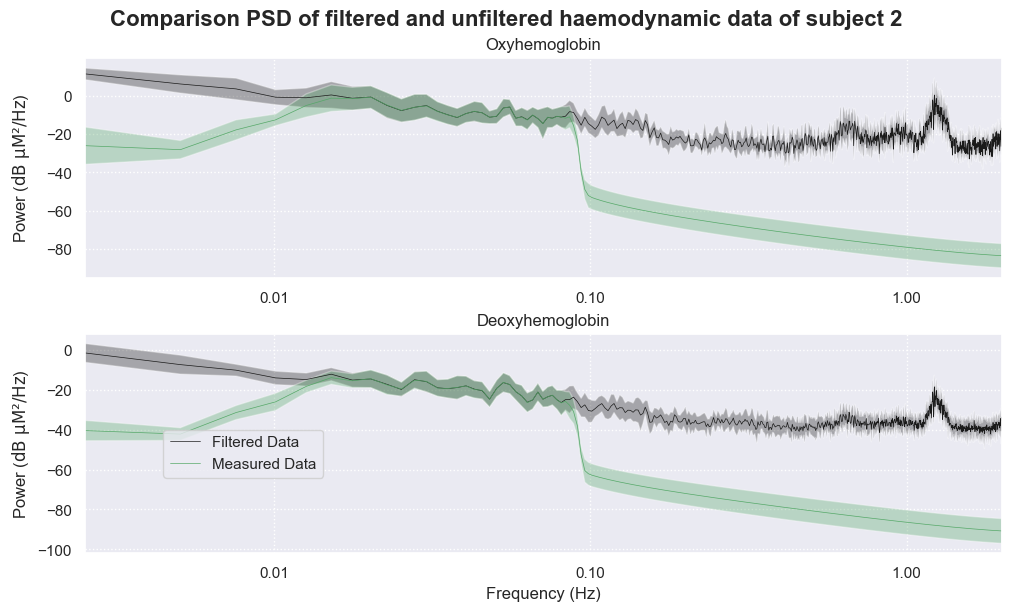

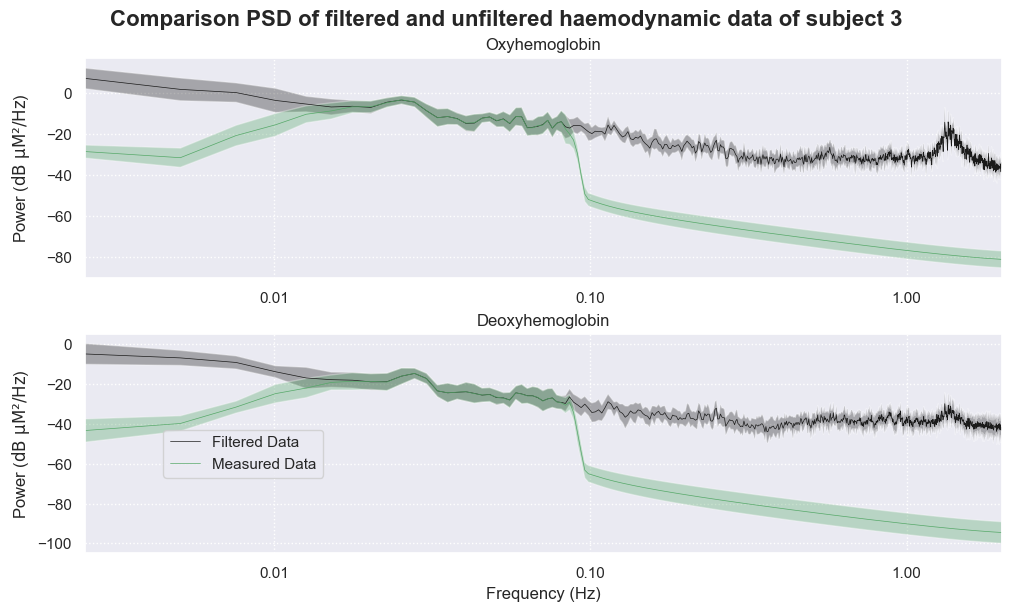

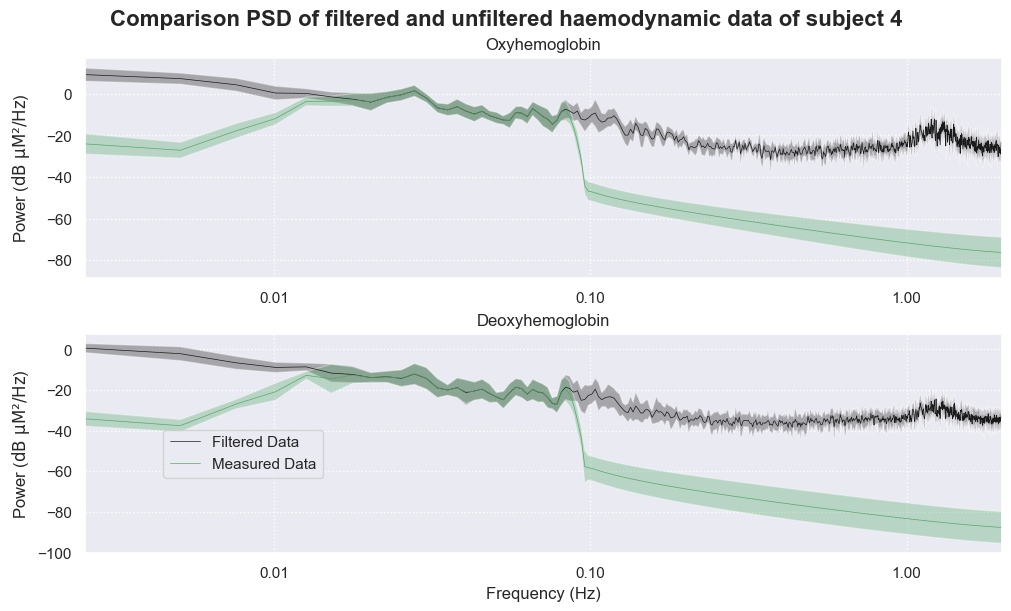

In [35]:
for sub in range(4):
    fig = raw_haemos[sub].plot_psd(average=True, fmax=2, xscale='log', color='k', show=False);
    raw_haemos_filtered[sub].plot_psd(average=True, fmax=2, xscale='log', ax=fig.axes, color='g', show=False);
    leg_lines = [line for line in fig.axes[0].lines if line.get_linestyle() == '-']
    fig.legend(leg_lines, ['Filtered Data', 'Measured Data'], loc="lower left", bbox_to_anchor=(0.15, 0.2))
    fig.suptitle('Comparison PSD of filtered and unfiltered haemodynamic data of subject ' + str(sub + 1), fontsize=16, fontweight='bold')
    if export:
        fig.savefig('Block_avg/PSD_comparison_after_BPF_subject_' + str(sub+1) + '.png')

## Post-processing <a class="anchor" id="chapter_2"></a>

Block averaging is used in block-design experiments, where a stimulus is presented continuously for an extended time interval, followed by an inter-stimulus interval where no stimulus is presented, in which the HR returns to an approximate base level. 

The procedure of block averaging can be divided in three steps:
1. **Segmentation:**  After pre-processing, the continuous fNIRS signal is divided into segments or epochs based on the timing of the task and rest periods.
2. **Averaging:** In block averaging, the noise component of the fNIRS signals is assumed to be a random process with zero mean, and unrelated to the biological signal of interest. Therefore, the corresponding segments from multiple repetitions of the task are averaged together relative to the onset of the stimulus. This averaging process reduces random noise, improving the SNR and thus highlighting the consistent HR associated with the brain activation related to the task.
3. **Analysis:** Finally, the averaged HRF is analyzed to determine the brain’s response to the task. Statistical metrics are used to compare the task and baseline periods, helping to identify significant changes in HbO and HbR.


### Segmentation and averaging <a class="anchor" id="section_2_1"></a>

In [36]:
# Remove practice grasping events from analysis
events_filtered = []
event_dicts_filtered = []
for sub in range(4):
    raw = raw_haemos_filtered[sub].copy()
    raw.annotations.delete(np.nonzero(raw.annotations.description == "practice/RIGHT"))
    raw.annotations.delete(np.nonzero(raw.annotations.description == "practice/LEFT"))
    event, event_dict = mne.events_from_annotations(raw)
    events_filtered.append(event)
    event_dicts_filtered.append(event_dict)

Used Annotations descriptions: ['Baseline', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'test/LEFT', 'test/RIGHT']


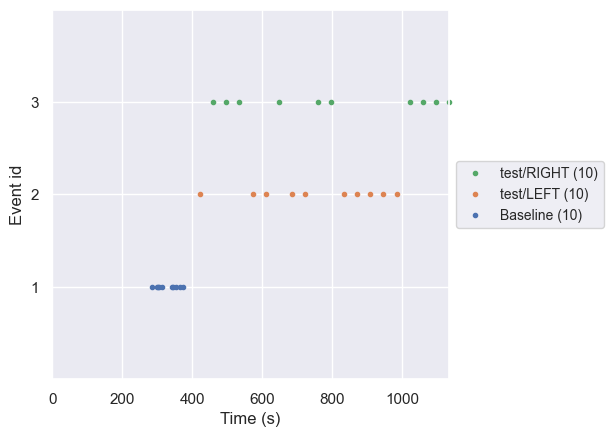

In [37]:
# Visualize events again for subject 1 (see earlier)
mne.viz.plot_events(events_filtered[0], event_id=event_dicts_filtered[0], sfreq=raw_intensities[0].info['sfreq']);

#### Extract epochs <a class="anchor" id="sub_section_2_1_1"></a>

##### Define the range of epochs, the rejection criteria, baseline correction and extract the epochs

In [38]:
# Define rejection criteria
reject_criteria = dict(hbo=80e-6)
# Define start and end of epoch
tmin, tmax = -5, 25

# Create epochs
epochs = []
for sub in range(4):
    epochs.append(mne.Epochs(raw_haemos_filtered[sub], events_filtered[sub], event_id=event_dicts_filtered[sub], tmin=tmin, tmax=tmax, preload=True, reject=reject_criteria, reject_by_annotation=True, baseline=(None, 0)))

Not setting metadata
30 matching events found
Setting baseline interval to [-5.018, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 157 original time points ...
0 bad epochs dropped
Not setting metadata
30 matching events found
Setting baseline interval to [-5.018, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 157 original time points ...
0 bad epochs dropped
Not setting metadata
30 matching events found
Setting baseline interval to [-5.018, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 157 original time points ...
0 bad epochs dropped
Not setting metadata
30 matching events found
Setting baseline interval to [-5.018, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 157 origin

In [39]:
#sample rate not perfectly matched
for sub in range(4):
    print('Subject ' + str(sub+1) + ':')
    print(epochs[sub])

Subject 1:
<Epochs |  30 events (all good), -5.018 – 25.09 s, baseline -5.018 – 0 s, ~1.8 MB, data loaded,
 'Baseline': 10
 'test/LEFT': 10
 'test/RIGHT': 10>
Subject 2:
<Epochs |  30 events (all good), -5.018 – 25.09 s, baseline -5.018 – 0 s, ~1.8 MB, data loaded,
 'Baseline': 10
 'test/LEFT': 10
 'test/RIGHT': 10>
Subject 3:
<Epochs |  30 events (all good), -5.018 – 25.09 s, baseline -5.018 – 0 s, ~1.8 MB, data loaded,
 'Baseline': 10
 'test/LEFT': 10
 'test/RIGHT': 10>
Subject 4:
<Epochs |  30 events (all good), -5.018 – 25.09 s, baseline -5.018 – 0 s, ~1.8 MB, data loaded,
 'Baseline': 10
 'test/LEFT': 10
 'test/RIGHT': 10>


##### Plot the PSD of the epoched data

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\406522363.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[0].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax1);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\406522363.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[1].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax2);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\406522363.py:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[2].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax3);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\406522363.py:6: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[3].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax4);


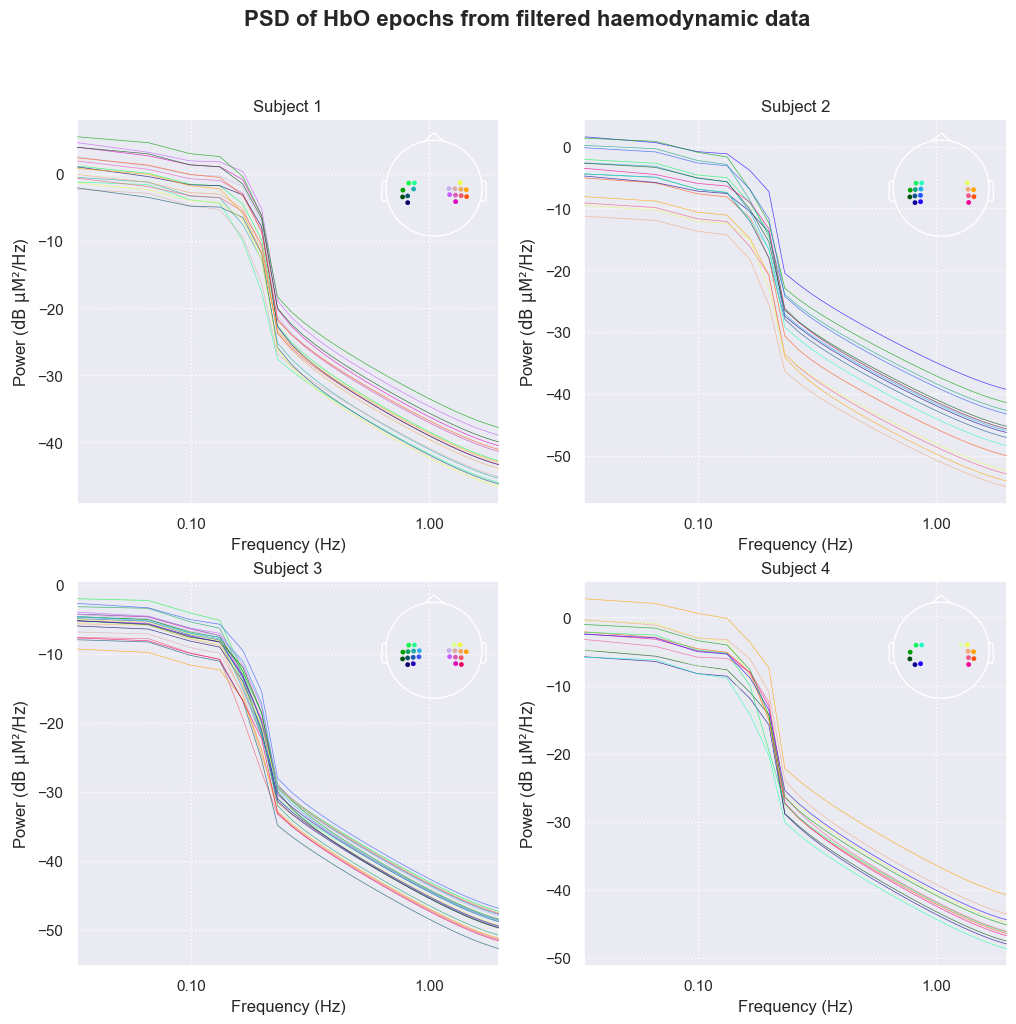

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,11))

epochs[0].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax1);
epochs[1].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax2);
epochs[2].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax3);
epochs[3].copy().pick(picks='hbo').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax4);
ax1.set_title('Subject 1')
ax2.set_title('Subject 2')
ax3.set_title('Subject 3')
ax4.set_title('Subject 4')
ax1.set_xlabel('Frequency (Hz)')
ax2.set_xlabel('Frequency (Hz)')
ax3.set_xlabel('Frequency (Hz)')
ax4.set_xlabel('Frequency (Hz)')

fig.suptitle('PSD of HbO epochs from filtered haemodynamic data', fontsize=16, fontweight='bold')

if export:
    fig.savefig('Block_avg/PSD_HbO_epochs.png')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1863602029.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[0].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax1);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1863602029.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[1].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax2);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1863602029.py:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[2].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax3);


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\1863602029.py:6: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs[3].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax4);


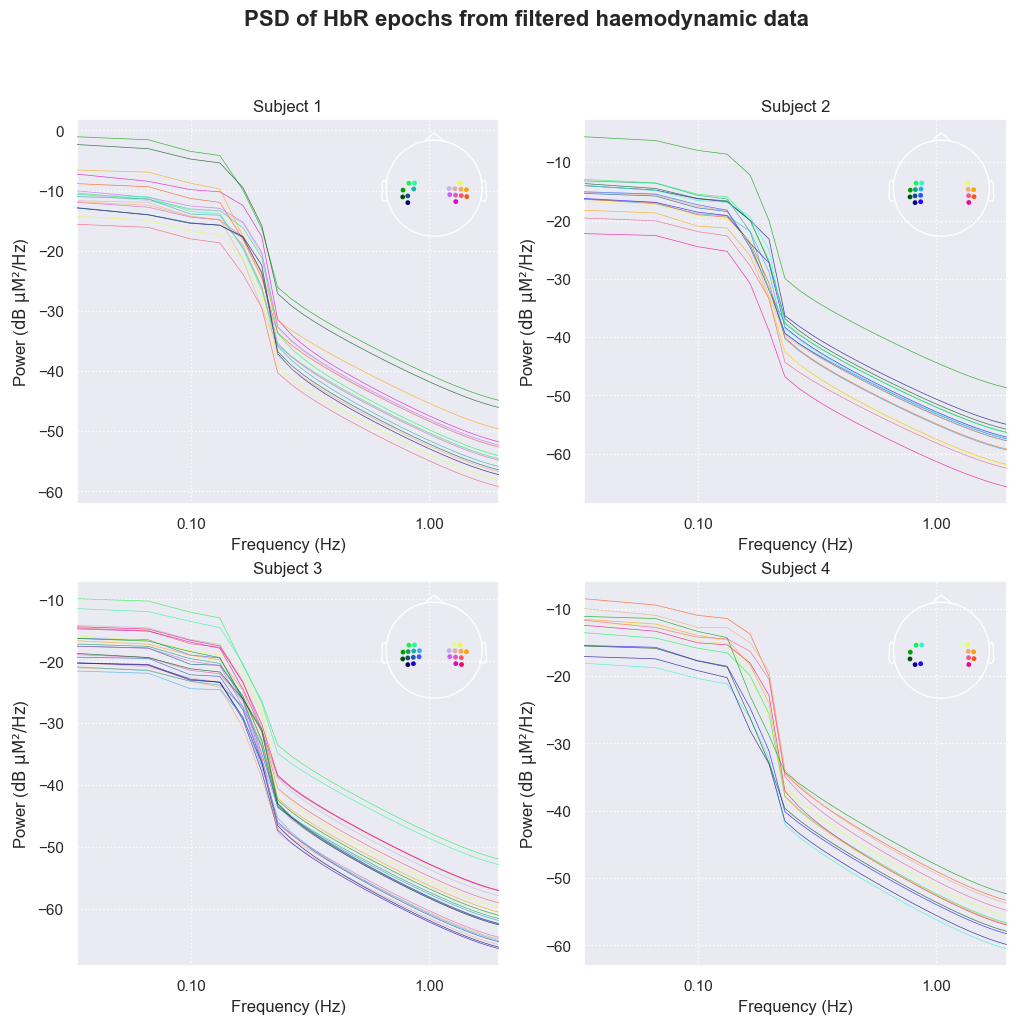

In [41]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,11))

epochs[0].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax1);
epochs[1].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax2);
epochs[2].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax3);
epochs[3].copy().pick(picks='hbr').plot_psd(average=False, exclude="bads", fmax=2, xscale='log', color='k', show=False, ax = ax4);
ax1.set_title('Subject 1')
ax2.set_title('Subject 2')
ax3.set_title('Subject 3')
ax4.set_title('Subject 4')
ax1.set_xlabel('Frequency (Hz)')
ax2.set_xlabel('Frequency (Hz)')
ax3.set_xlabel('Frequency (Hz)')
ax4.set_xlabel('Frequency (Hz)')

fig.suptitle('PSD of HbR epochs from filtered haemodynamic data', fontsize=16, fontweight='bold')

if export:
    fig.savefig('Block_avg/PSD_HbR_epochs.png')

---
*Remark:*
-  There are no epochs with deviating frequency spectrums
-  There are no epochs removed
-  Only good channels are used

##### Plot the epoched data of the hand grasping

###### Subject 1

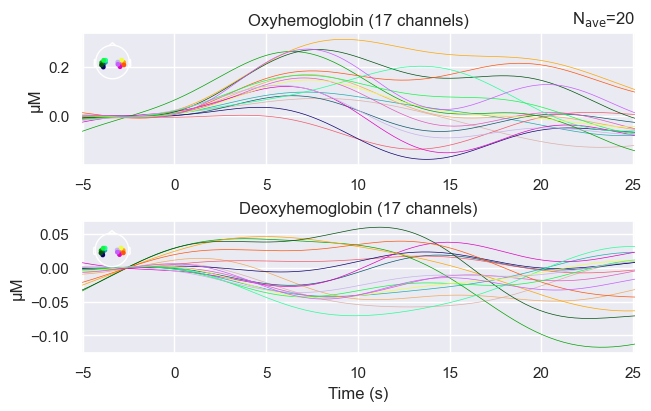

In [42]:
fig = epochs[0]['test'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_grasping_subject_1.png')

###### Subject 2

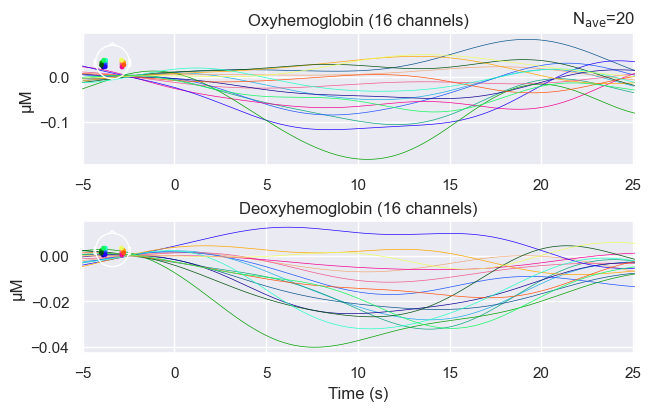

In [43]:
fig = epochs[1]['test'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_grasping_subject_2.png')

###### Subject 3

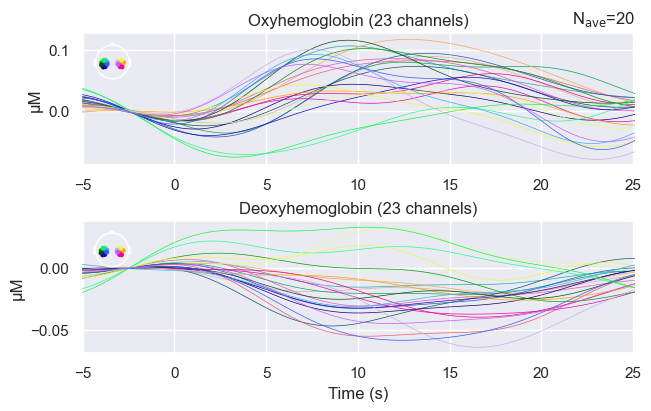

In [44]:
fig = epochs[2]['test'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_grasping_subject_3.png')

###### Subject 4

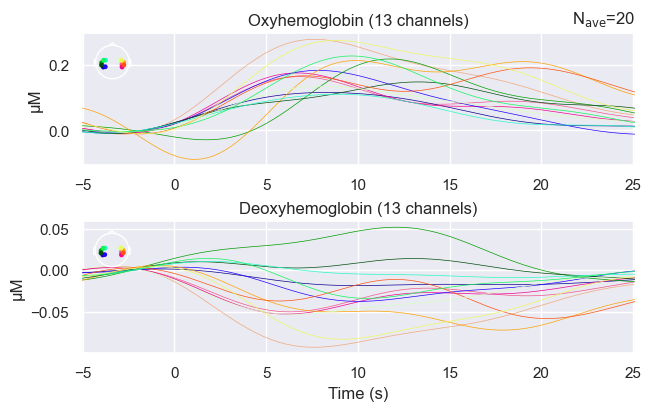

In [45]:
fig = epochs[3]['test'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_grasping_subject_4.png')

##### Plot the epoched data of the control segments

###### Subject 1

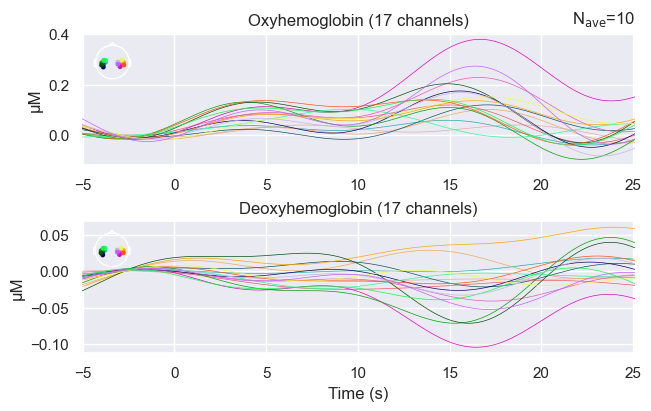

In [46]:
fig = epochs[0]['Baseline'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_control_subject_1.png')

###### Subject 2

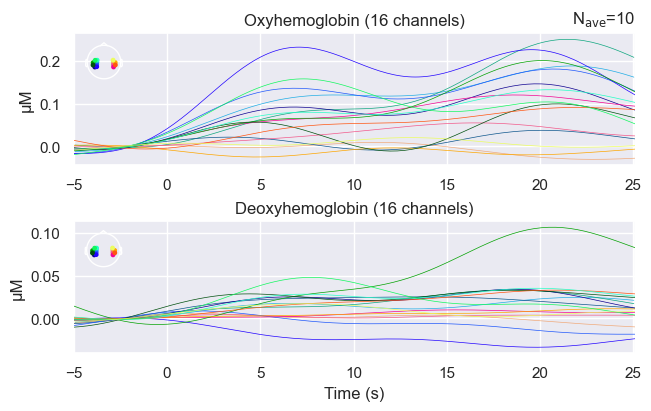

In [47]:
fig = epochs[1]['Baseline'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_control_subject_2.png')

###### Subject 3

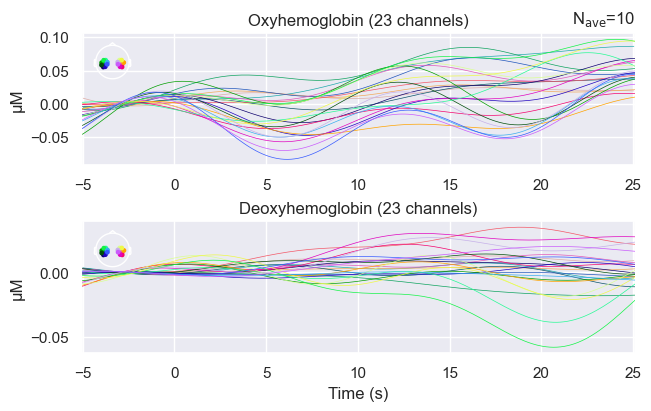

In [48]:
fig = epochs[2]['Baseline'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_control_subject_3.png')

###### Subject 4

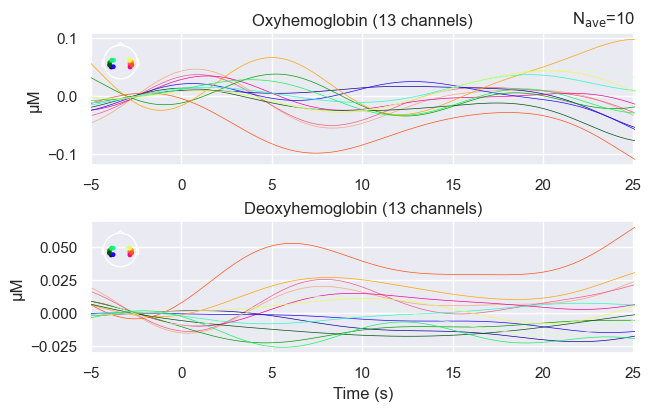

In [49]:
fig = epochs[3]['Baseline'].average().plot()
if export:
    fig.savefig('Block_avg/epochs_control_subject_4.png')

---
> *Remark:*
- We expect to see the HRF in the grasping trials
- The control segments should not show HRF
---

##### View consistency of responses across trials

In [50]:
# Show for subject 1
if plot:
    # Grasping
    %matplotlib inline
    epochs[0]["test"].copy().pick('hbo').plot_image(combine="mean", vmin=-0.25, vmax=0.25, ts_args=dict(ylim=dict(hbo=[-0.25, 0.25], hbr=[-0.1, 0.1])))
    epochs[0]["test"].copy().pick('hbr').plot_image(combine="mean", vmin=-0.1, vmax=0.1, ts_args=dict(ylim=dict(hbo=[-0.25, 0.25], hbr=[-0.1, 0.1])))

In [51]:
# Show for subject 1
if plot:
    # Control
    %matplotlib inline
    epochs[0]["Baseline"].copy().pick('hbo').plot_image(combine="mean", vmin=-0.25, vmax=0.25, ts_args=dict(ylim=dict(hbo=[-0.25, 0.25], hbr=[-0.1, 0.1])))
    epochs[0]["Baseline"].copy().pick('hbr').plot_image(combine="mean", vmin=-0.1, vmax=0.1, ts_args=dict(ylim=dict(hbo=[-0.25, 0.25], hbr=[-0.1, 0.1])))

##### View consistency of responses across channels

In [52]:
# Show for subject 1
if plot:
    %matplotlib qt
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), layout="constrained")
    clims = dict(hbo=[-0.25, 0.25], hbr=[-0.1, 0.1])
    epochs[0]["Baseline"].average().plot_image(axes=axes[:, 0], clim=clims)
    epochs[0]["test"].average().plot_image(axes=axes[:, 1], clim=clims)
    for column, condition in enumerate(["Baseline", "test"]):
        for ax in axes[:, column]:
            ax.set_title("{}: {}".format(condition, ax.get_title()))
    if export:
        fig.savefig('epoch_across_channels_subject_1.png')

---
> *Remark:*
- Variation in HRF strength over epochs and channels
---

#### Average epochs <a class="anchor" id="sub_section_2_1_2"></a>

##### Plot the PSD of the averaged epoched data

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\3087428040.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = epochs[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\3087428040.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = epochs[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\3087428040.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = epochs[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\fabia\AppData\Local\Temp\ipykernel_2272\3087428040.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = epochs[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


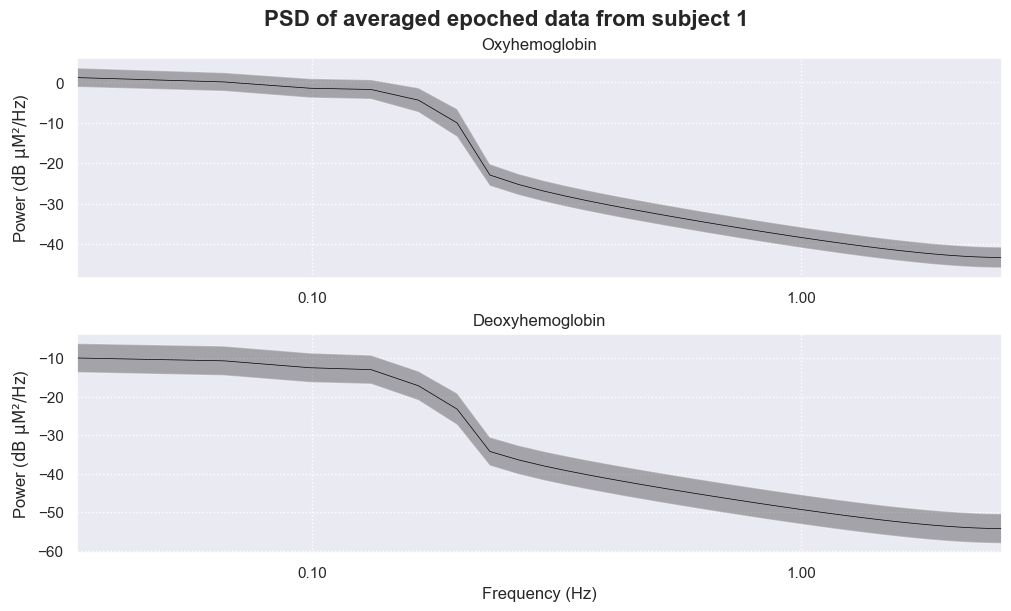

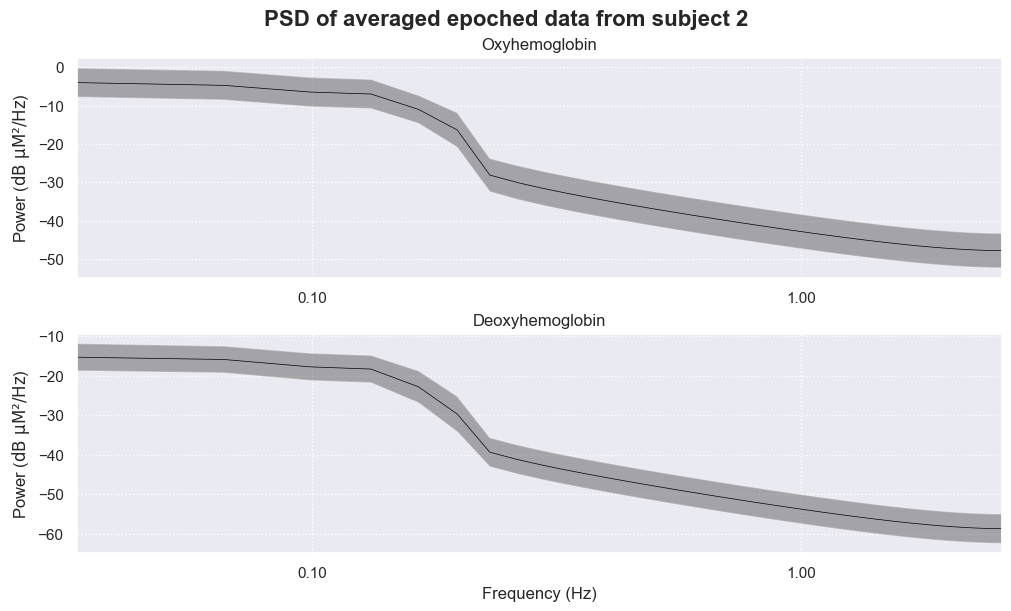

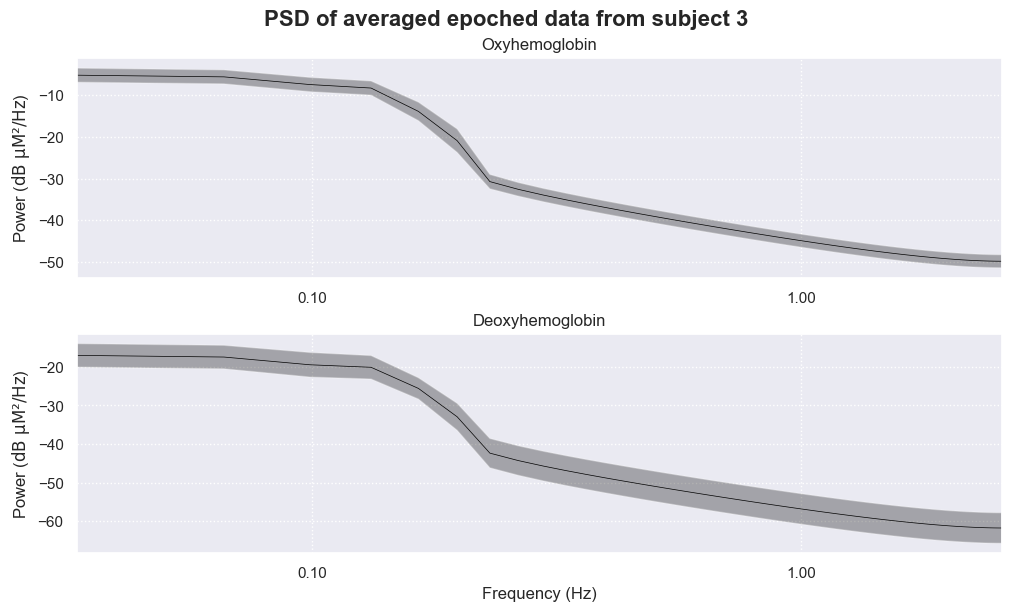

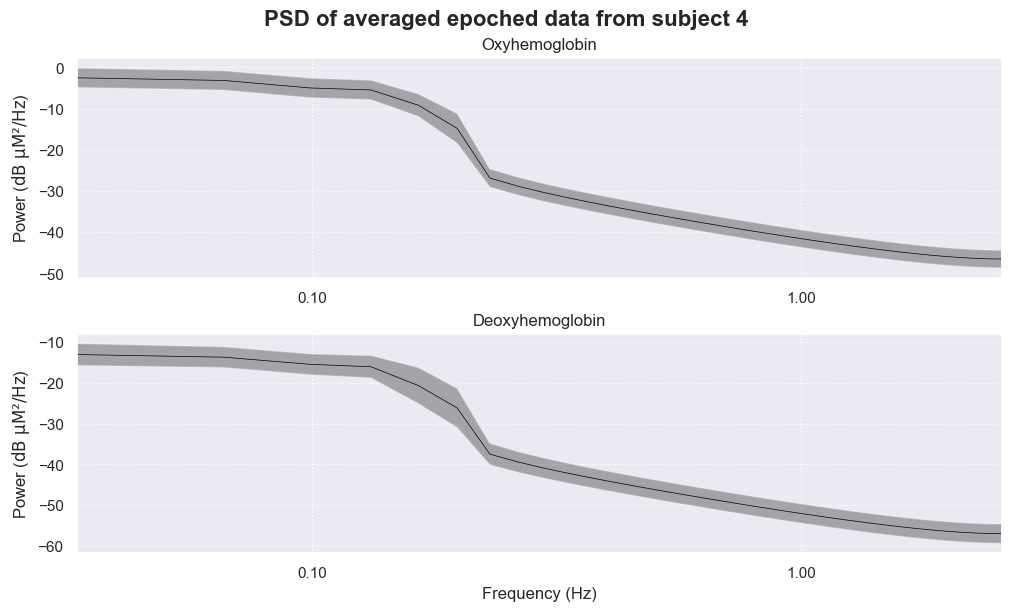

In [53]:
%matplotlib inline
for sub in range(4):
    fig = epochs[sub].compute_psd().plot(average=True, exclude="bads", xscale='log')
    fig.suptitle('PSD of averaged epoched data from subject ' + str(sub+1), fontsize=16, fontweight='bold')
    if export:
        fig.savefig('PSD_averaged_epochs_subject_' + str(sub + 1) + '.png')

---
*Remark:*
-  Averaging the epochs removes some of the systemic components that are not time locked to the stimulus

##### Plot standard fNIRS response image

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


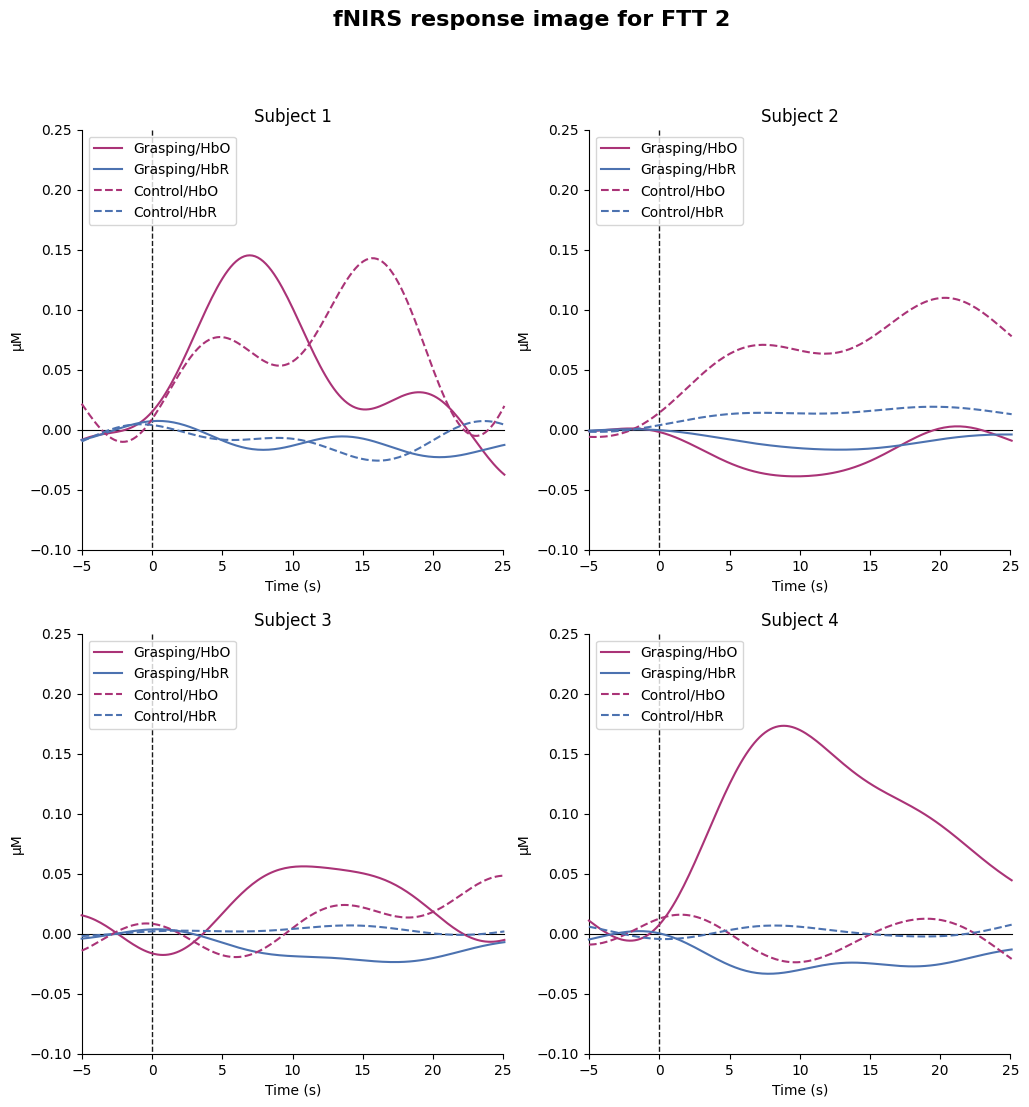

In [54]:
sns.reset_defaults()
evoked_dicts = []
for sub in range(4):
    evoked_dict = {
        "Grasping/HbO": epochs[sub]["test"].average(picks="hbo"),
        "Grasping/HbR": epochs[sub]["test"].average(picks="hbr"),
        "Control/HbO": epochs[sub]["Baseline"].average(picks="hbo"),
        "Control/HbR": epochs[sub]["Baseline"].average(picks="hbr"),
    }
    evoked_dicts.append(evoked_dict)

# Rename channels until the encoding of frequency in ch_name is fixed
for sub in range(4):
    for condition in evoked_dicts[sub]:
        evoked_dicts[sub][condition].rename_channels(lambda x: x[:-4])

%matplotlib inline

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))
mne.viz.plot_compare_evokeds(evoked_dicts[0], combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, ylim=dict(hbo=[-0.1, 0.25]), axes = ax1, show = False);
mne.viz.plot_compare_evokeds(evoked_dicts[1], combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, ylim=dict(hbo=[-0.1, 0.25]), axes = ax2, show = False);
mne.viz.plot_compare_evokeds(evoked_dicts[2], combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, ylim=dict(hbo=[-0.1, 0.25]), axes = ax3, show = False);
mne.viz.plot_compare_evokeds(evoked_dicts[3], combine="mean", ci=0.95, colors=color_dict, styles=styles_dict, ylim=dict(hbo=[-0.1, 0.25]), axes = ax4, show = False);
ax1.set_title('Subject 1')
ax2.set_title('Subject 2')
ax3.set_title('Subject 3')
ax4.set_title('Subject 4')

fig.suptitle('fNIRS response image for FTT 2', fontsize=16, fontweight='bold')

if export:
    fig.savefig('Block_avg/Response_image.png')

---
> *Remark:*
- Control segments have values near zero
- HRF not visible in subject 2
---

##### Combine epochs of the four subjects

In [146]:
all_evokeds = defaultdict(list)
for sub in range(4):
    for cidx, condition in enumerate(epochs[sub].event_id):
        all_evokeds[condition].append(epochs[sub][condition].average())

In [147]:
all_evokeds

defaultdict(list,
            {'Baseline': [<Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~108 kB>,
              <Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>],
             'test/LEFT': [<Evoked | 'test/LEFT' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | 'test/LEFT' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | 'test/LEFT' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~108 kB>,
              <Evoked | 'test/LEFT' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>],
             'test/RIGHT': [<Evoked | 'test/RIGHT' (average, N=10), -5.

In [151]:
all_evokeds2 = defaultdict(list)
for sub in range(4):
    all_evokeds2['Baseline'].append(epochs[sub]['Baseline'].average())
    all_evokeds2['Grasping'].append(epochs[sub]['test'].average())

In [152]:
all_evokeds2

defaultdict(list,
            {'Baseline': [<Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~108 kB>,
              <Evoked | 'Baseline' (average, N=10), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>],
             'Grasping': [<Evoked | '0.50 × test/LEFT + 0.50 × test/RIGHT' (average, N=20), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | '0.50 × test/LEFT + 0.50 × test/RIGHT' (average, N=20), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~109 kB>,
              <Evoked | '0.50 × test/LEFT + 0.50 × test/RIGHT' (average, N=20), -5.018 – 25.09 s, baseline -5.018 – 0 s, 48 ch, ~108 kB>,
              <Evoked | '0.50 × test/LEFT + 0.50 × test/RIGHT' (average, N=20), -5.018 – 25.09 s, basel

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


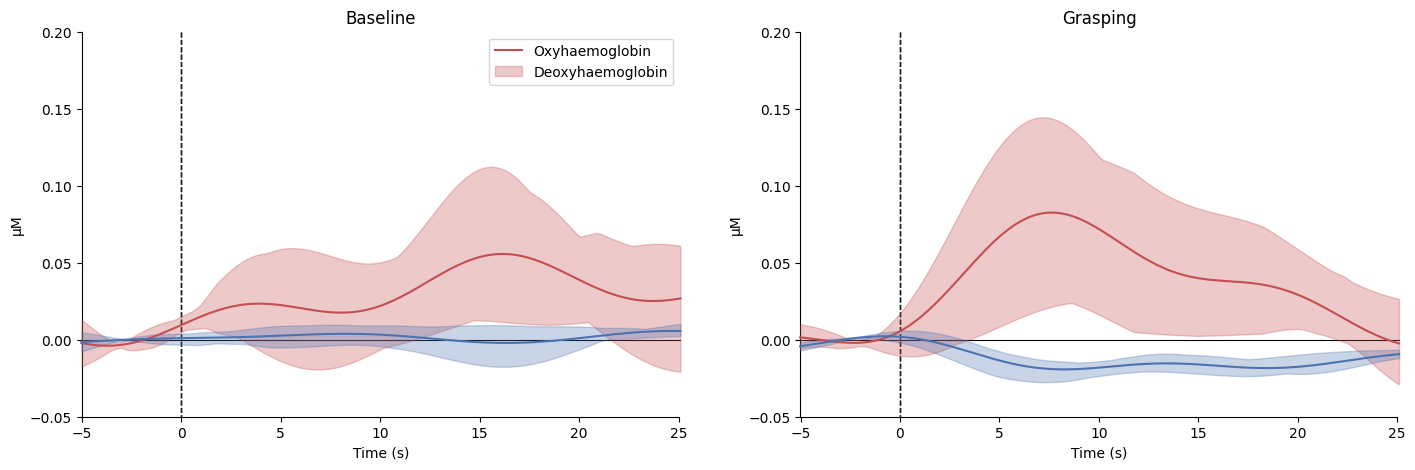

In [156]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
lims = dict(hbo=[-0.05, 0.2], hbr=[-0.05, 0.2])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds2):
        mne.viz.plot_compare_evokeds({evoked: all_evokeds2[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

if export:
    fig.savefig('Block_avg/HRF_all_epochs.png')

---
> *Remark:*
- No big difference between control and grasping
---

#### Topographic representation <a class="anchor" id="sub_section_2_1_3"></a>

##### Plot hemisphere for each approach

In [81]:
left = [[1, 1], [3, 1], [5, 1], [7, 1], [5, 3], [7, 3], [3, 5], [5, 5], [1, 7], [3, 7], [1, 9], [7, 9]]
right = [[2, 2], [4, 2], [6, 2], [8, 2], [6, 4], [8, 4], [4, 6], [6, 6], [2, 8], [4, 8], [2, 10], [8, 10]]

rois = dict(Left_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy().pick(picks='hbo'), left, on_missing='warning'),
              Right_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy().pick(picks='hbo'), right, on_missing='warning'))

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


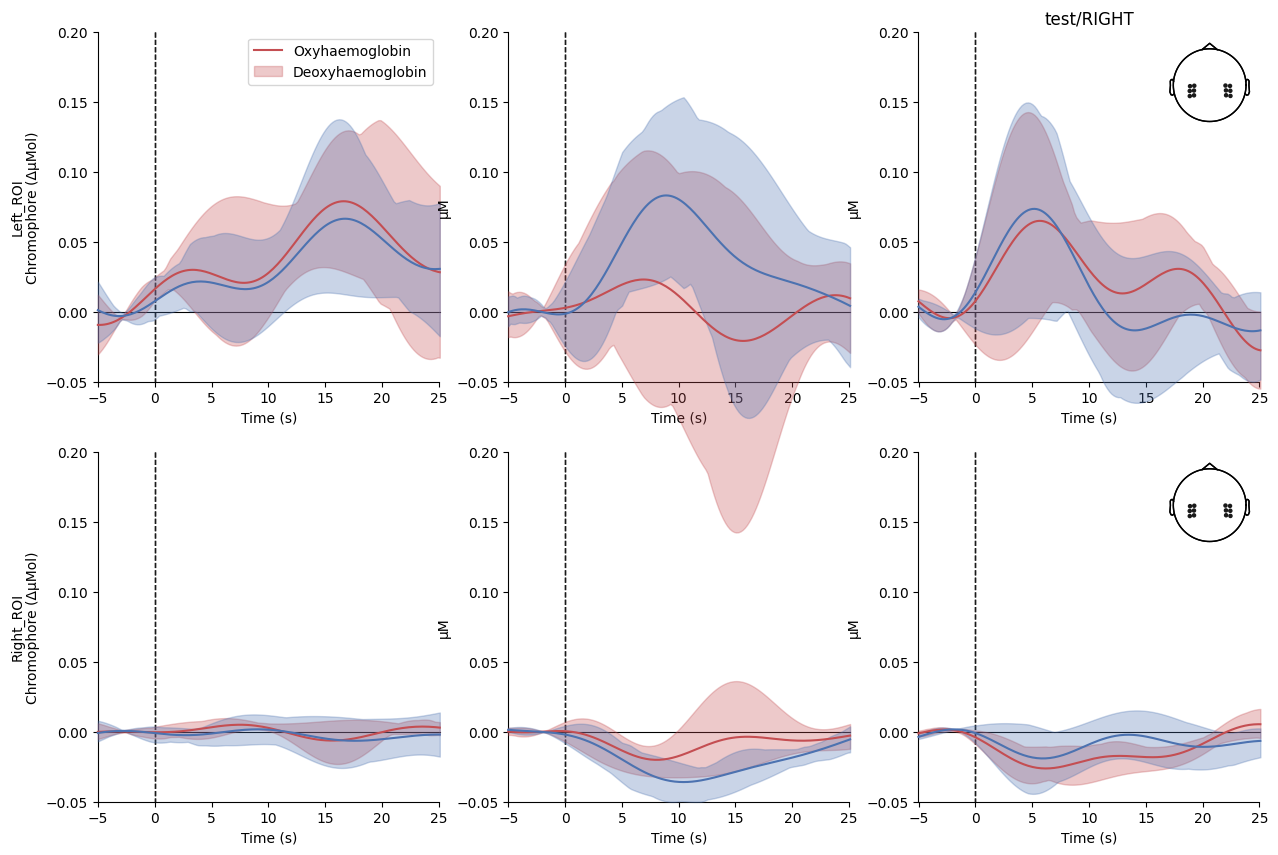

In [59]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds), figsize=(15, 10))

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == 'hbr':
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            mne.viz.plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                                 picks=picks, axes=axes[ridx, cidx],
                                 show=False, colors=[color], legend=False,
                                 ylim=lims, ci=0.95, show_sensors=cidx == 2)
            axes[ridx, cidx].set_title("")
        axes[0, cidx].set_title(f"{evoked}")
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")
axes[0, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

if export:
    fig.savefig('Block_avg/HRF_topograph_all_epochs.png')

---
> *Remark:*
- We expected to see a HRF with larger amplitude in left hemisphere compared to right hemisphere for right hand grasping and vice versa for left hand grasping
- Amplitude of right hemisphere overal lower
- No negative correlation between HbO and HbR
---

##### Topographic representation of activity

No projector specified for this dataset. Please consider the method self.add_proj.


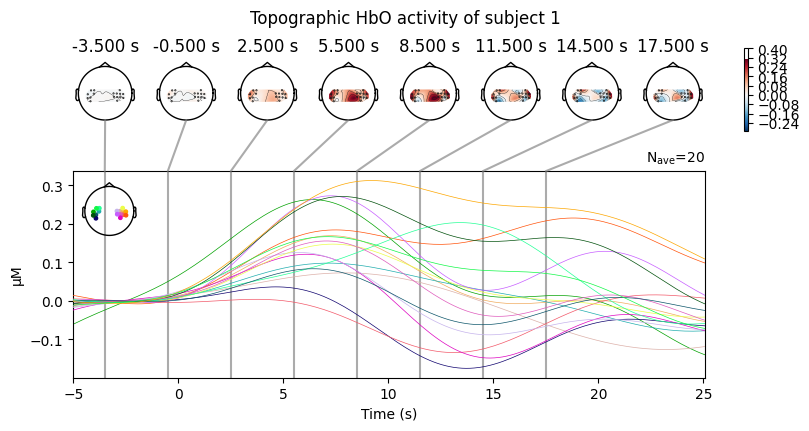

No projector specified for this dataset. Please consider the method self.add_proj.


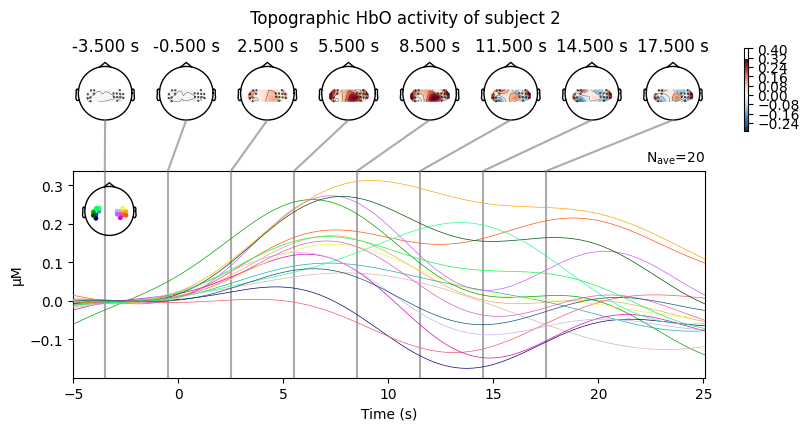

No projector specified for this dataset. Please consider the method self.add_proj.


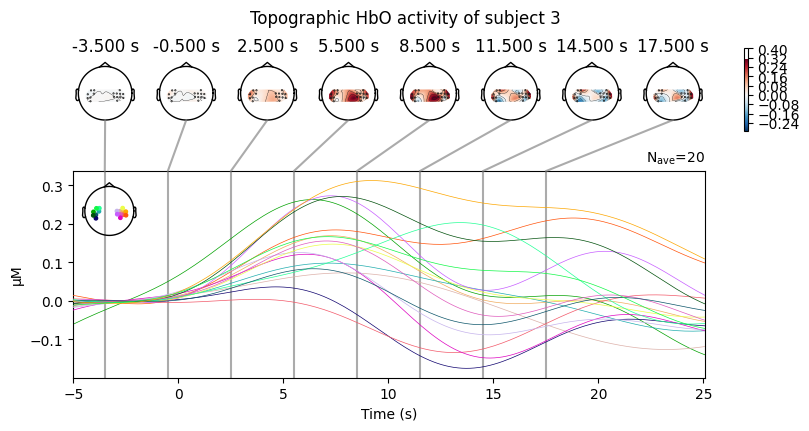

No projector specified for this dataset. Please consider the method self.add_proj.


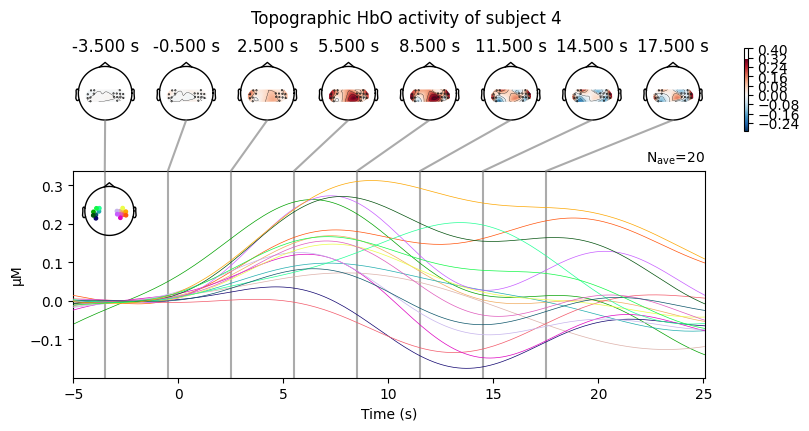

In [60]:
%matplotlib inline
# HbO
times = np.arange(-3.5, 20.2, 3.0)
topomap_args = dict(extrapolate="local")
for sub in range(4):
    fig = epochs[0]["test"].average(picks="hbo").plot_joint(times=times, topomap_args=topomap_args, title = 'Topographic HbO activity of subject ' + str(sub+1))
    if export:
        fig.savefig('Block_avg/Topographic_HbO_activity_subject_' + str(sub+1)+ '.png')

No projector specified for this dataset. Please consider the method self.add_proj.


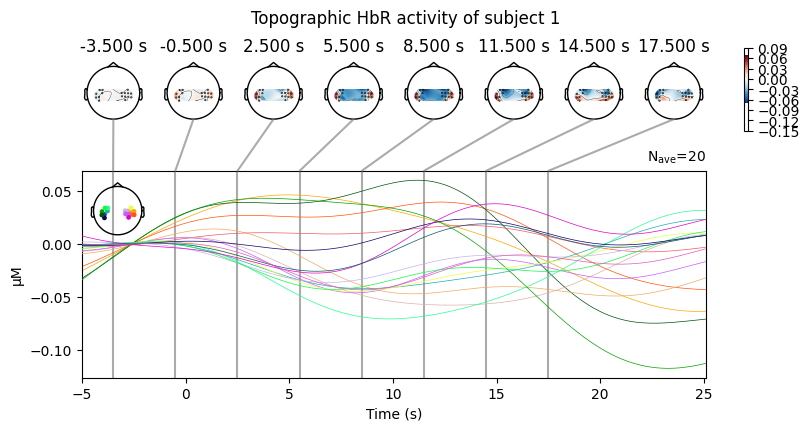

No projector specified for this dataset. Please consider the method self.add_proj.


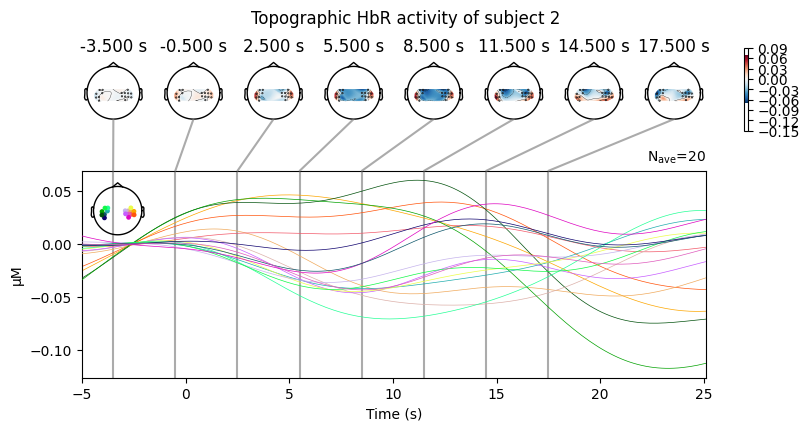

No projector specified for this dataset. Please consider the method self.add_proj.


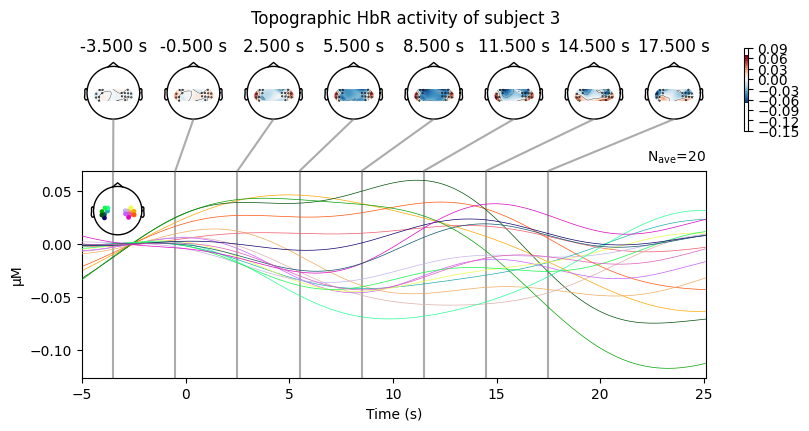

No projector specified for this dataset. Please consider the method self.add_proj.


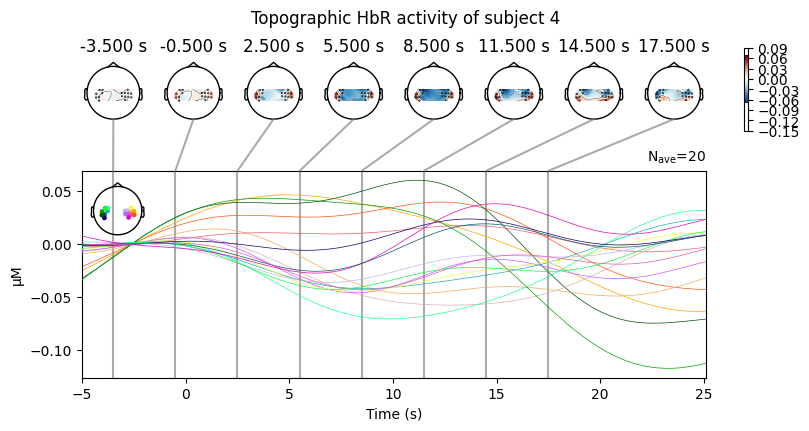

In [61]:
# HbR
%matplotlib inline
times = np.arange(-3.5, 20.2, 3.0)
topomap_args = dict(extrapolate="local")
for sub in range(4):
    fig = epochs[0]["test"].average(picks="hbr").plot_joint(times=times, topomap_args=topomap_args, title = 'Topographic HbR activity of subject ' + str(sub+1))
    if export:
        fig.savefig('Block_avg/Topographic_HbR_activity_subject_' + str(sub+1)+ '.png')

##### Compare grasping of left and right hands

No projector specified for this dataset. Please consider the method self.add_proj.


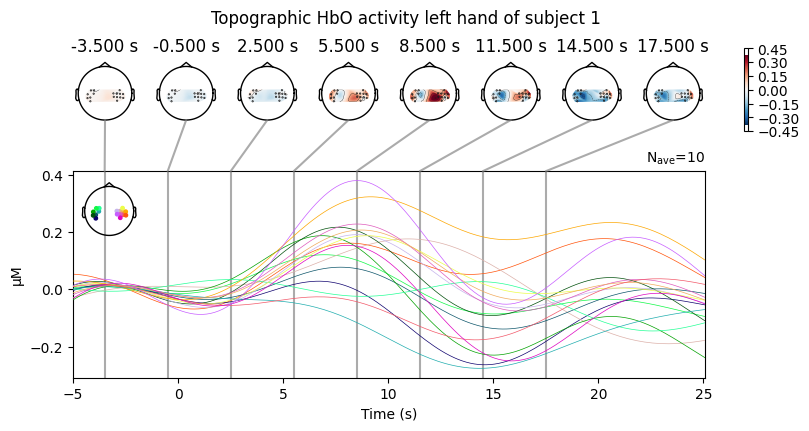

No projector specified for this dataset. Please consider the method self.add_proj.


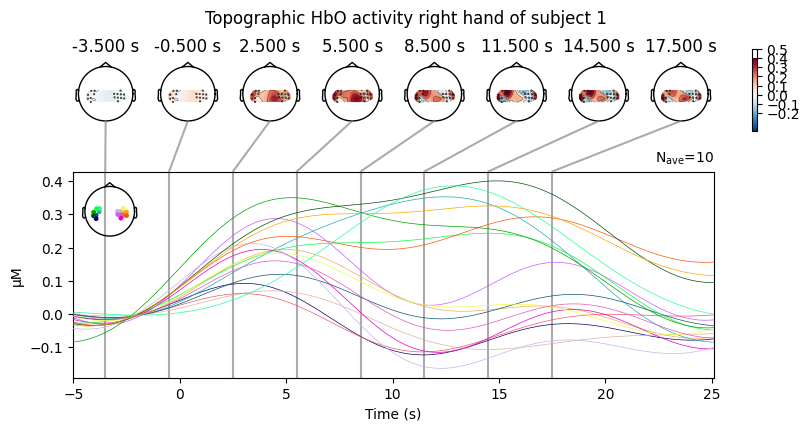

No projector specified for this dataset. Please consider the method self.add_proj.


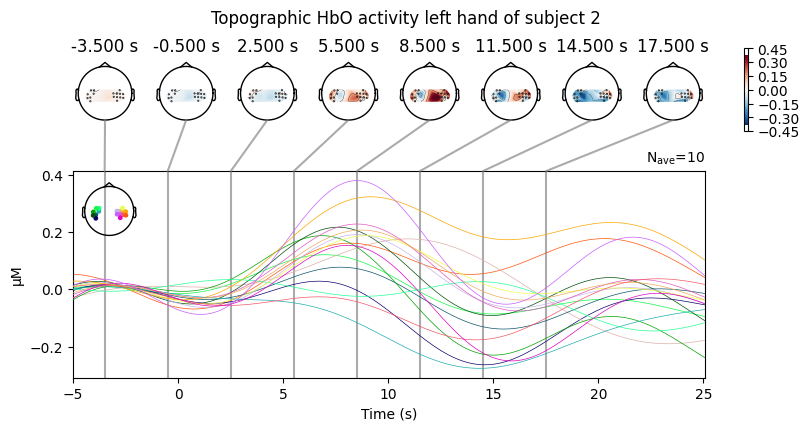

No projector specified for this dataset. Please consider the method self.add_proj.


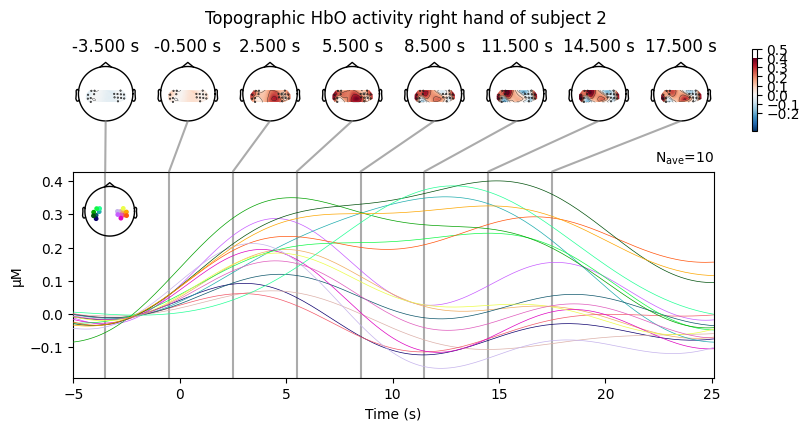

No projector specified for this dataset. Please consider the method self.add_proj.


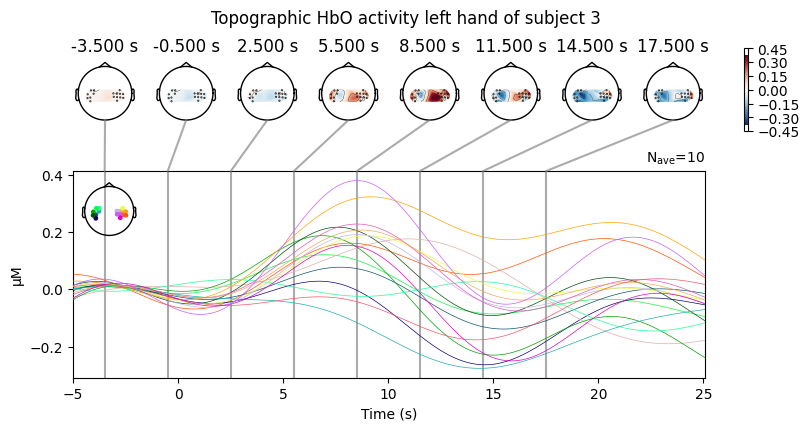

No projector specified for this dataset. Please consider the method self.add_proj.


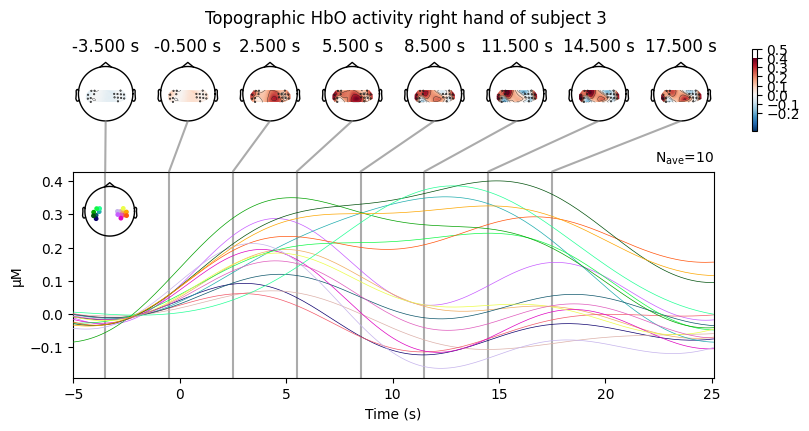

No projector specified for this dataset. Please consider the method self.add_proj.


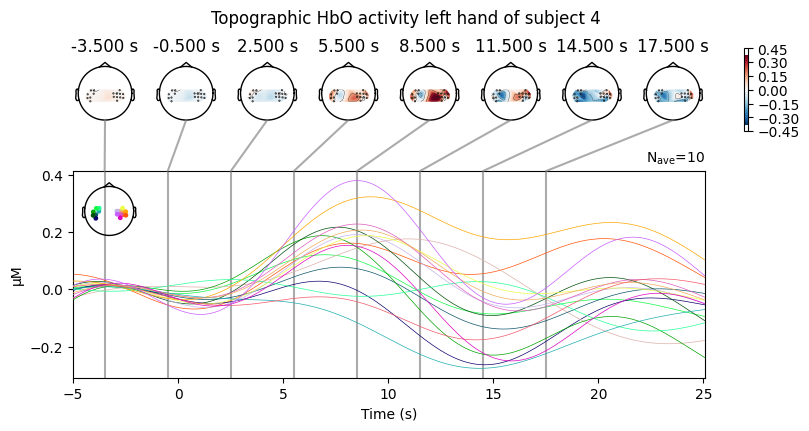

No projector specified for this dataset. Please consider the method self.add_proj.


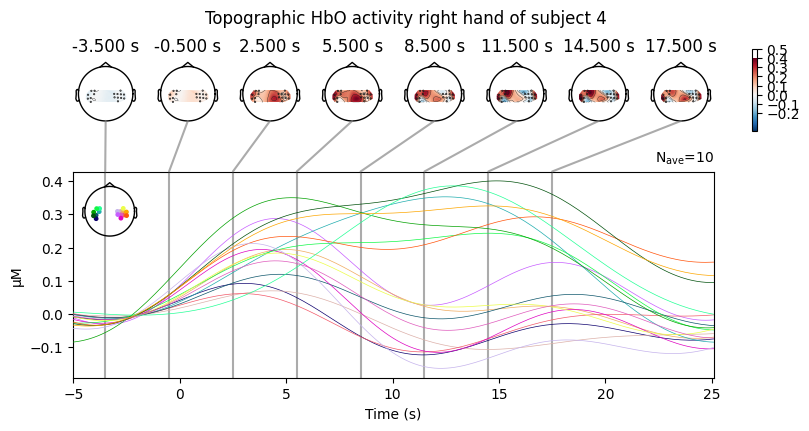

In [62]:
# HbO
times = np.arange(-3.5, 20.2, 3.0)
topomap_args = dict(extrapolate="local")
for sub in range(4):
    fig1 = epochs[0]["test/LEFT"].average(picks="hbo").plot_joint(times=times, topomap_args=topomap_args, title = 'Topographic HbO activity left hand of subject ' + str(sub+1))
    fig2 = epochs[0]["test/RIGHT"].average(picks="hbo").plot_joint(times=times, topomap_args=topomap_args, title = 'Topographic HbO activity right hand of subject ' + str(sub+1))
    if export:
        fig1.savefig('Block_avg/Topographic_HbO_activity_left_hand_subject_' + str(sub+1)+ '.png')
        fig2.savefig('Block_avg/Topographic_HbO_activity_right_hand_subject_' + str(sub+1)+ '.png')

No projector specified for this dataset. Please consider the method self.add_proj.


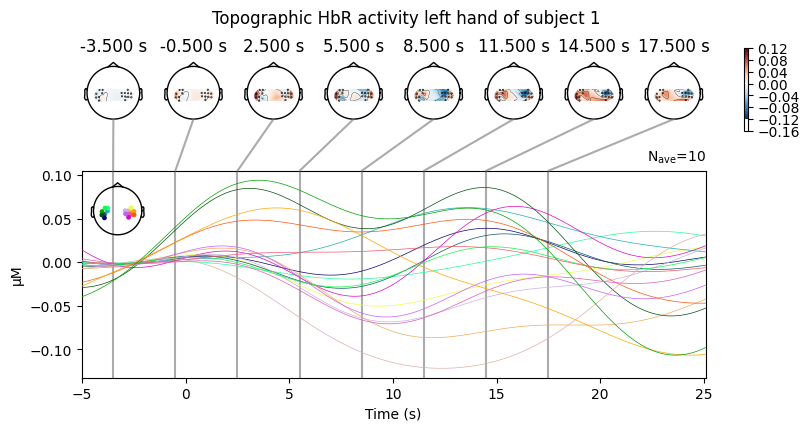

No projector specified for this dataset. Please consider the method self.add_proj.


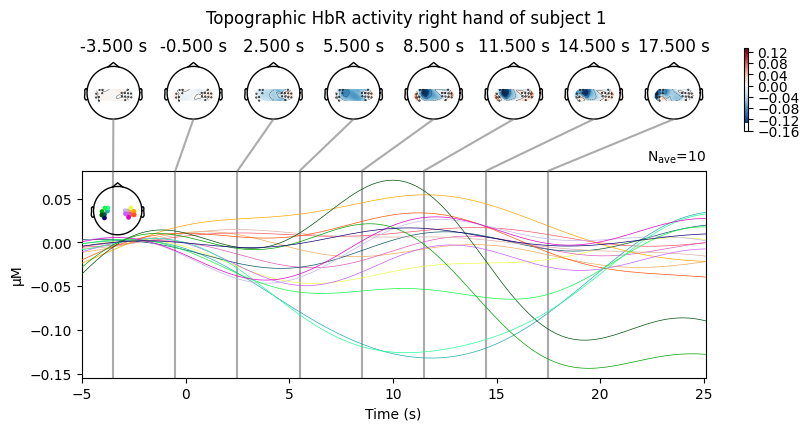

No projector specified for this dataset. Please consider the method self.add_proj.


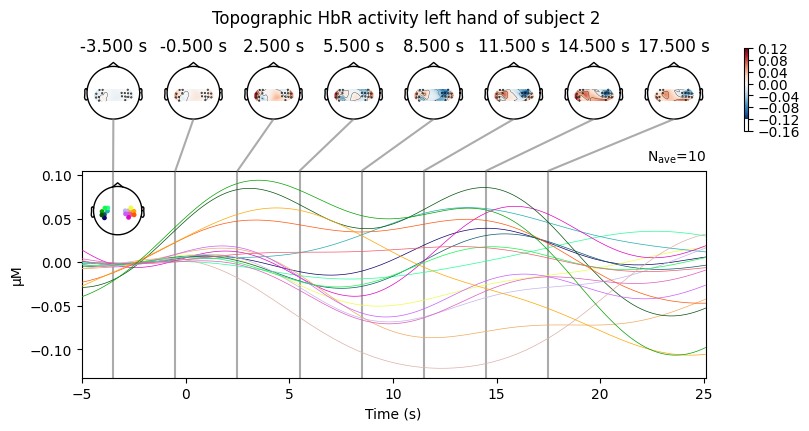

No projector specified for this dataset. Please consider the method self.add_proj.


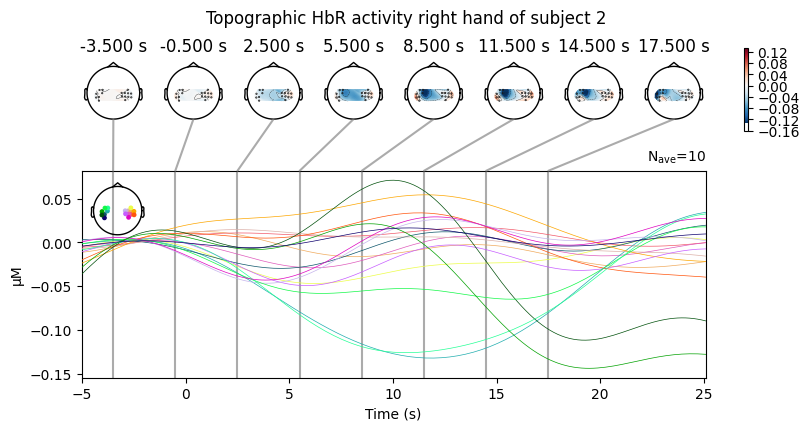

No projector specified for this dataset. Please consider the method self.add_proj.


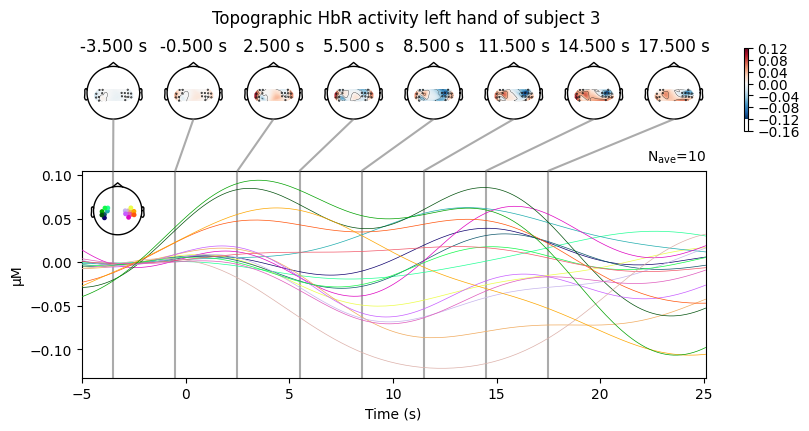

No projector specified for this dataset. Please consider the method self.add_proj.


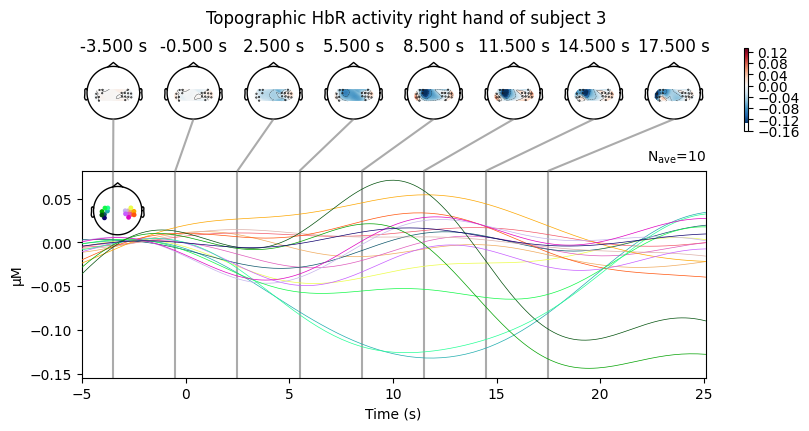

No projector specified for this dataset. Please consider the method self.add_proj.


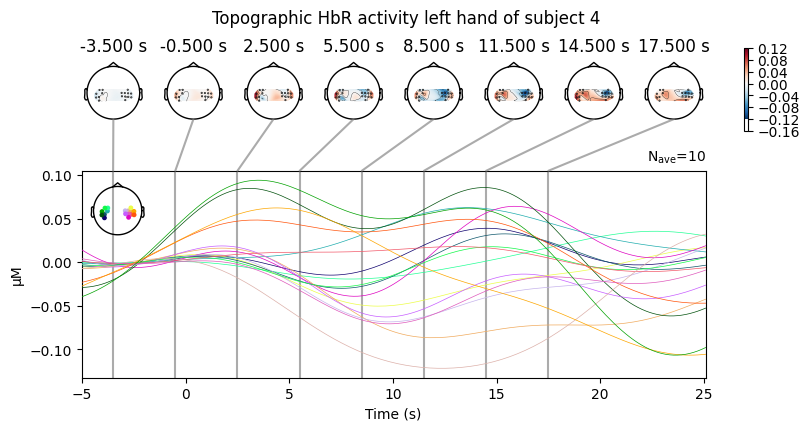

No projector specified for this dataset. Please consider the method self.add_proj.


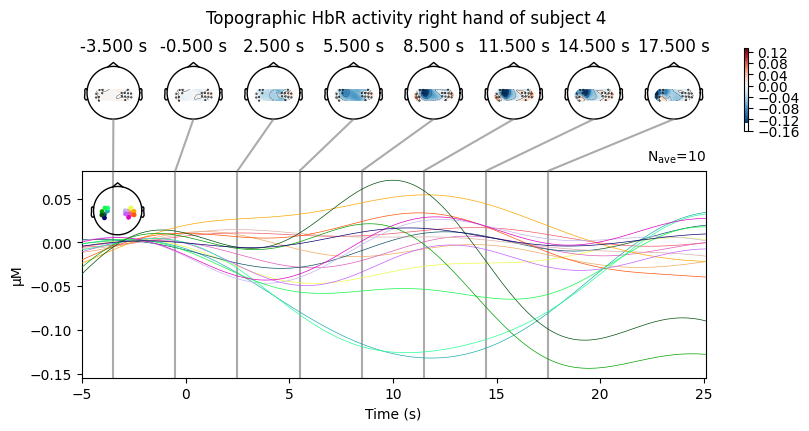

In [63]:
# HbR
times = np.arange(-3.5, 20.2, 3.0)
topomap_args = dict(extrapolate="local")
for sub in range(4):
    fig1 = epochs[0]["test/LEFT"].average(picks="hbr").plot_joint(times=times, topomap_args=topomap_args, title = 'Topographic HbR activity left hand of subject ' + str(sub+1))
    fig2 = epochs[0]["test/RIGHT"].average(picks="hbr").plot_joint(times=times, topomap_args=topomap_args, title = 'Topographic HbR activity right hand of subject ' + str(sub+1))
    if export:
        fig1.savefig('Block_avg/Topographic_HbR_activity_left_hand_subject_' + str(sub+1)+ '.png')
        fig2.savefig('Block_avg/Topographic_HbR_activity_right_hand_subject_' + str(sub+1)+ '.png')

Topographic HbO activity left hand of subject 1


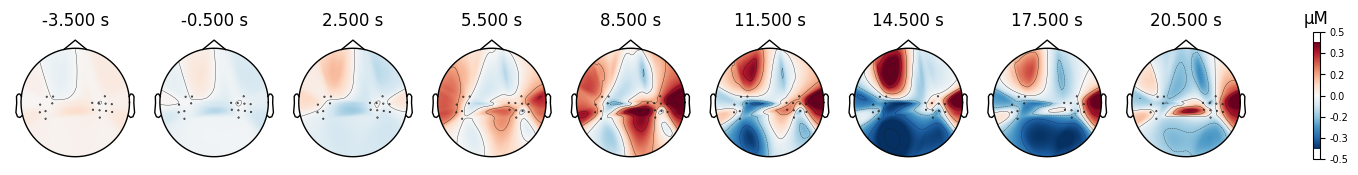

Topographic HbO activity right hand of subject 1


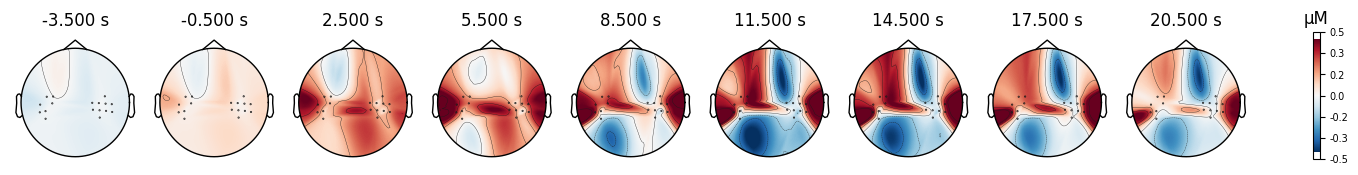

Topographic HbO activity left hand of subject 2


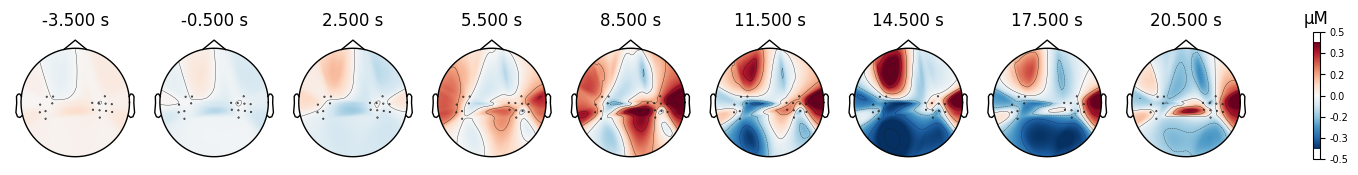

Topographic HbO activity right hand of subject 2


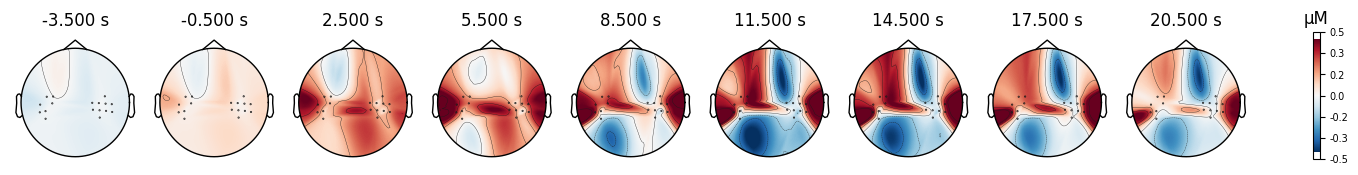

Topographic HbO activity left hand of subject 3


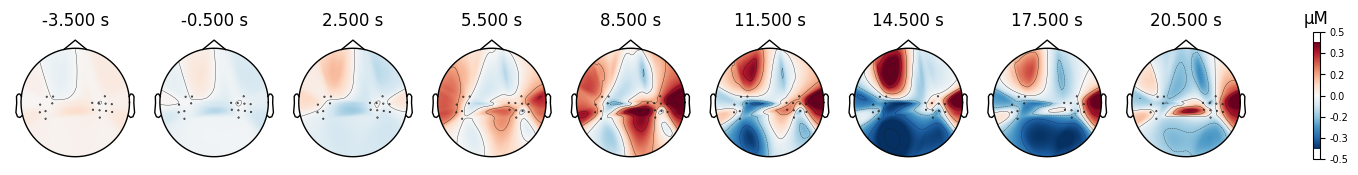

Topographic HbO activity right hand of subject 3


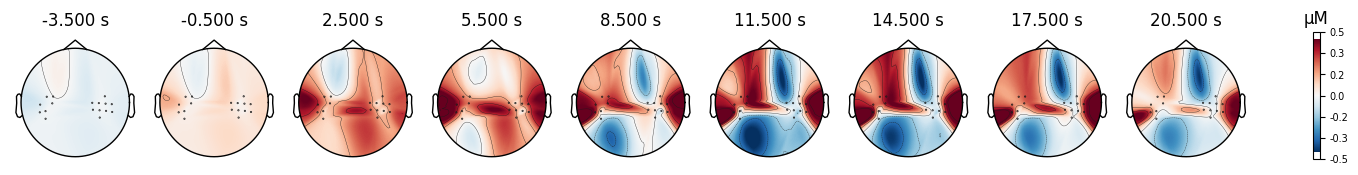

Topographic HbO activity left hand of subject 4


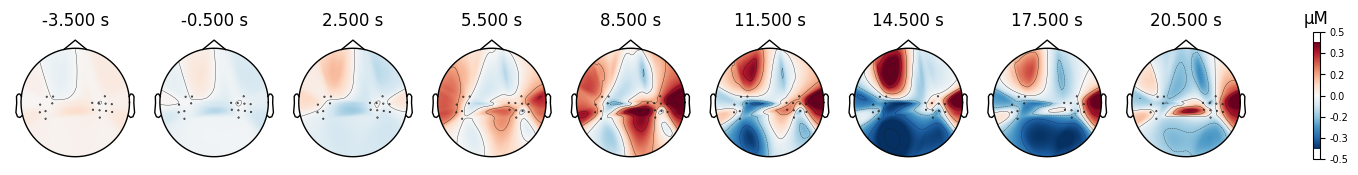

Topographic HbO activity right hand of subject 4


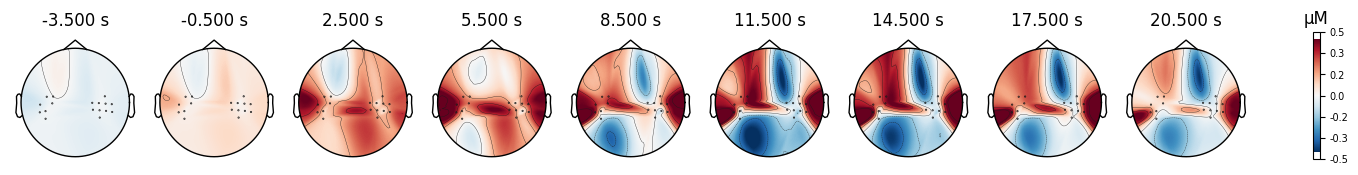

In [64]:
# HbO
times = np.arange(-3.5, 23.2, 3.0)
topomap_args = dict(extrapolate="local")
for sub in range(4):
    print('Topographic HbO activity left hand of subject ' + str(sub+1))
    fig1 = epochs[0]["test/LEFT"].average(picks="hbo").plot_topomap(times = times)
    print('Topographic HbO activity right hand of subject ' + str(sub+1))
    fig2 = epochs[0]["test/RIGHT"].average(picks="hbo").plot_topomap(times = times)
    if export:
        fig1.savefig('Block_avg/Topographic_HbO_left_hand_subject_' + str(sub+1)+ '.png')
        fig2.savefig('Block_avg/Topographic_HbO_right_hand_subject_' + str(sub+1)+ '.png')

---
*Remark:*
- Interpolation used to give topomap of full head
- Lateralization of activity 


### Statistical analysis <a class="anchor" id="section_2_2"></a>

For classical statistical analysis, the time course data are divided into segments corresponding to different conditions, such as baseline and activation periods. The averaged values from these segments (or parts of these segments) are then used for standard statistical analysis. Consequently, block averaging overlooks the detailed time course of the HRF, which is essential for in-depth NIRS analysis. The following sections will discuss four specific parametric statistical metrics (one sample t-test, two sample t-test, paired t-test, and ANOVA) in more detail, based on work by Tak et al. (2014). 

Since these tests are parametric tests, some assumptions that need to be met by the data:
1. **Normality:** The sample data should be drawn from a population that follows an approximately normal distribution. This could be tested with the Kolmogorov-Smirnov test, which has no assumption about the distribution of the data.
2. **Homogeneity of variance:** The sample data should come from a population with uniform variance (F-test).
3. **Independence:** The observations in the sample data should be independent of each other and randomly sampled.
4. **Outliers:** The sample data should be free of extreme outliers.

#### Extract data from epochs  <a class="anchor" id="sub_section_2_2_1"></a>

For each subject, ROI, chromophore and condition, we extracted three different features of the epochs:
1. Mean value of the complete epoch
2. Mean value of the epoch during the stimulus duration + Delay due to bluetooth transfer of data
3. Mean value of the HRF peak (5-7 s after onset) + Delay due to bluetooth transfer of data

In [166]:
rois = dict(Left_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), left, on_missing='warning'),
              Right_ROI=picks_pair_to_idx(raw_haemos_filtered[0].copy(), right, on_missing='warning'))

In [167]:
# For RQ2
df = pd.DataFrame(columns=['ID', 'ROI', 'Chroma', 'Condition', 'Mean_epoch', 'Mean_task', 'Mean_HRF'])

DelayBluetooth = 5 # Estimated during MA experiment to be 5 seconds
StimDur = 12 # 12 s grasping movement

for idx, evoked in enumerate(all_evokeds):
    subj_id = 0
    for subj_data in all_evokeds[evoked]:
        subj_id += 1
        for roi in rois:
            for chroma in ["hbo", "hbr"]:
                data = deepcopy(subj_data).pick(picks=rois[roi]).pick(chroma)
                value1 = data.data.mean() * 1.0e6
                value2 = data.copy().crop(tmin=DelayBluetooth, tmax=StimDur+DelayBluetooth).data.mean() * 1.0e6
                value3 = data.copy().crop(tmin=5.0 + DelayBluetooth, tmax=7.0 + DelayBluetooth).data.mean() * 1.0e6 # Amplitude of peak calue of HRF
                
                # Append metadata and extracted feature to dataframe
                this_df = pd.DataFrame(
                    {'ID': subj_id, 'ROI': roi, 'Chroma': chroma,
                     'Condition': evoked, 'Mean_epoch': value1, 'Mean_task': value2, 'Mean_HRF': value3}, index=[0])
                df = pd.concat([df, this_df], ignore_index=True)
df.reset_index(inplace=True, drop=True)
#df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object

# You can export the dataframe for analysis in your favorite stats program
df.to_csv("stats-export.csv")

# Print out the first entries in the dataframe
df.head(20)

ID        ROI Chroma  Condition  Mean_epoch  Mean_task  Mean_HRF
0   1   Left_ROI    hbo   Baseline    0.035790   0.062299  0.046013
1   1   Left_ROI    hbr   Baseline   -0.007449  -0.015013 -0.009891
2   1  Right_ROI    hbo   Baseline    0.065039   0.101730  0.075371
3   1  Right_ROI    hbr   Baseline   -0.009907  -0.015814 -0.010915
4   2   Left_ROI    hbo   Baseline    0.073146   0.081879  0.072979
5   2   Left_ROI    hbr   Baseline    0.011993   0.014505  0.012958
6   2  Right_ROI    hbo   Baseline    0.031043   0.031109  0.028983
7   2  Right_ROI    hbr   Baseline   -0.002213   0.000053  0.001044
8   3   Left_ROI    hbo   Baseline    0.013256   0.009945  0.016628
9   3   Left_ROI    hbr   Baseline   -0.001575  -0.000085 -0.000035
10  3  Right_ROI    hbo   Baseline    0.005467   0.003891  0.014088
11  3  Right_ROI    hbr   Baseline    0.006007   0.008507  0.008948
12  4   Left_ROI    hbo   Baseline   -0.004487  -0.005020 -0.004271
13  4   Left_ROI    hbr   Baseline   -0.002833  -0.003555 -0.004146
14  4  Right_ROI    hbo   Baseline   -0.004432  -0.015300 -0.020695
15  4  Right_ROI    hbr   Baseline    0.005936   0.009901  0.010723
16  1   Left_ROI    hbo  test/LEFT   -0.040576  -0.050104 -0.049547
17  1   Left_ROI    hbr  test/LEFT    0.012006   0.020571  0.018677
18  1  Right_ROI    hbo  test/LEFT    0.016182   0.055234  0.095551
19  1  Right_ROI    hbr  test/LEFT   -0.010248  -0.020575 -0.031642

In [183]:
# For RQ1
df2 = pd.DataFrame(columns=['ID', 'ROI', 'Chroma', 'Condition', 'Mean_epoch', 'Mean_task', 'Mean_HRF'])

DelayBluetooth = 5 # Estimated during MA experiment to be 5 seconds
StimDur = 12 # 12 s grasping movement

for idx, evoked in enumerate(all_evokeds2):
    subj_id = 0
    for subj_data in all_evokeds2[evoked]:
        subj_id += 1
        for roi in rois:
            for chroma in ["hbo", "hbr"]:
                data = deepcopy(subj_data).pick(picks=rois[roi]).pick(chroma)
                value1 = data.data.mean() * 1.0e6
                value2 = data.copy().crop(tmin=DelayBluetooth, tmax=StimDur+DelayBluetooth).data.mean() * 1.0e6
                value3 = data.copy().crop(tmin=5.0 + DelayBluetooth, tmax=7.0 + DelayBluetooth).data.mean() * 1.0e6 # Amplitude of peak calue of HRF
                
                # Append metadata and extracted feature to dataframe
                this_df = pd.DataFrame(
                    {'ID': subj_id, 'ROI': roi, 'Chroma': chroma,
                     'Condition': evoked, 'Mean_epoch': value1, 'Mean_task': value2, 'Mean_HRF': value3}, index=[0])
                df2 = pd.concat([df2, this_df], ignore_index=True)
df2.reset_index(inplace=True, drop=True)
#df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object

# You can export the dataframe for analysis in your favorite stats program
df2.to_csv("stats-export2.csv")

# Print out the first entries in the dataframe
df2.head(20)

ID        ROI Chroma Condition  Mean_epoch  Mean_task  Mean_HRF
0   1   Left_ROI    hbo  Baseline    0.035790   0.062299  0.046013
1   1   Left_ROI    hbr  Baseline   -0.007449  -0.015013 -0.009891
2   1  Right_ROI    hbo  Baseline    0.065039   0.101730  0.075371
3   1  Right_ROI    hbr  Baseline   -0.009907  -0.015814 -0.010915
4   2   Left_ROI    hbo  Baseline    0.073146   0.081879  0.072979
5   2   Left_ROI    hbr  Baseline    0.011993   0.014505  0.012958
6   2  Right_ROI    hbo  Baseline    0.031043   0.031109  0.028983
7   2  Right_ROI    hbr  Baseline   -0.002213   0.000053  0.001044
8   3   Left_ROI    hbo  Baseline    0.013256   0.009945  0.016628
9   3   Left_ROI    hbr  Baseline   -0.001575  -0.000085 -0.000035
10  3  Right_ROI    hbo  Baseline    0.005467   0.003891  0.014088
11  3  Right_ROI    hbr  Baseline    0.006007   0.008507  0.008948
12  4   Left_ROI    hbo  Baseline   -0.004487  -0.005020 -0.004271
13  4   Left_ROI    hbr  Baseline   -0.002833  -0.003555 -0.004146
14  4  Right_ROI    hbo  Baseline   -0.004432  -0.015300 -0.020695
15  4  Right_ROI    hbr  Baseline    0.005936   0.009901  0.010723
16  1   Left_ROI    hbo  Grasping    0.018916   0.040042  0.034676
17  1   Left_ROI    hbr  Grasping   -0.004027  -0.003317 -0.000057
18  1  Right_ROI    hbo  Grasping    0.029384   0.051157  0.046544
19  1  Right_ROI    hbr  Grasping   -0.006390  -0.009322 -0.010089

#### Mixed effect model <a class="anchor" id="sub_section_2_2_2"></a>

##### Research question 1:  Comparison of control and task condition

###### Control vs Grasping

The LMM for each measurement ($y$) for each subject can thus be represented by:

$$
y_{ij} = \beta_0 + \beta_1 \cdot \text{condition}_{ij} + u_j + \epsilon_{ij}
$$

where:
- $y_{ij}$: The feature for the $i$-th observation of the $j$-th subject.
- u$\beta_0$: The fixed intercept, representing the overall mean of the feature across all conditions.
- $\beta_1$: The fixed effect slope associated with the condition, showing how the condition affects the feature.
- $u_j$: The random intercept for the $j$-th subject, which accounts for the subject-specific deviation from the global intercept $\beta_0$. It is assumed to follow a normal distribution: 

$$
u_j \sim N(0, \sigma_u^2)
$$

where $\sigma_u^2$ is the variance of the random intercepts.

- $\epsilon_{ij}$: The residual error for the $i$-th observation of the $j$-th subject, capturing the deviation of the observed feature value from the predicted feature value after accounting for both fixed and random effects. It is assumed to follow a normal distribution:

$$
\epsilon_{ij} \sim N(0, \sigma_\epsilon^2)
$$

where $\sigma_\epsilon^2$ is the variance of the residuals.


In [184]:
# Extract control and (left and right) grasping data
input_data = df2.query("Condition in ['Baseline', 'Grasping']")
# Extract only HbO data
input_data = input_data.query("Chroma in ['hbo']")

input_data

ID        ROI Chroma Condition  Mean_epoch  Mean_task  Mean_HRF
0   1   Left_ROI    hbo  Baseline    0.035790   0.062299  0.046013
2   1  Right_ROI    hbo  Baseline    0.065039   0.101730  0.075371
4   2   Left_ROI    hbo  Baseline    0.073146   0.081879  0.072979
6   2  Right_ROI    hbo  Baseline    0.031043   0.031109  0.028983
8   3   Left_ROI    hbo  Baseline    0.013256   0.009945  0.016628
10  3  Right_ROI    hbo  Baseline    0.005467   0.003891  0.014088
12  4   Left_ROI    hbo  Baseline   -0.004487  -0.005020 -0.004271
14  4  Right_ROI    hbo  Baseline   -0.004432  -0.015300 -0.020695
16  1   Left_ROI    hbo  Grasping    0.018916   0.040042  0.034676
18  1  Right_ROI    hbo  Grasping    0.029384   0.051157  0.046544
20  2   Left_ROI    hbo  Grasping   -0.020858  -0.045128 -0.054453
22  2  Right_ROI    hbo  Grasping   -0.001533   0.002094  0.007959
24  3   Left_ROI    hbo  Grasping    0.019821   0.046003  0.057468
26  3  Right_ROI    hbo  Grasping    0.023591   0.052352  0.058176
28  4   Left_ROI    hbo  Grasping    0.060809   0.099415  0.102593
30  4  Right_ROI    hbo  Grasping    0.084739   0.130155  0.128174

In [191]:
# Mean over full epoch
full_epoch_model = smf.mixedlm("Mean_epoch ~ Condition", input_data,
                        groups=input_data["ID"]).fit()
full_epoch_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   Mean_epoch
No. Observations:   16        Method:               REML      
No. Groups:         4         Scale:                0.0010    
Min. group size:    4         Log-Likelihood:       26.3964   
Max. group size:    4         Converged:            No        
Mean group size:    4.0                                       
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.027    0.011 2.398 0.017  0.005  0.049
Condition[T.Grasping] 0.000    0.016 0.000 1.000 -0.031  0.031
Group Var             0.000                                   
==============================================================

"""

In [186]:
# Mean over stimulus duration
full_stimulus_model = smf.mixedlm("Mean_task ~ Condition", input_data,
                        groups=input_data["ID"]).fit()
full_stimulus_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   Mean_task
No. Observations:    16        Method:               REML     
No. Groups:          4         Scale:                0.0024   
Min. group size:     4         Log-Likelihood:       20.3256  
Max. group size:     4         Converged:            Yes      
Mean group size:     4.0                                      
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.034    0.017 1.959 0.050 -0.000  0.068
Condition[T.Grasping] 0.013    0.024 0.540 0.589 -0.035  0.061
Group Var             0.000    0.016                          
==============================================================

"""

In [187]:
HRF_epoch_model = smf.mixedlm("Mean_HRF ~ Condition", input_data,
                        groups=input_data["ID"]).fit()
HRF_epoch_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   Mean_HRF
No. Observations:     16        Method:               REML    
No. Groups:           4         Scale:                0.0022  
Min. group size:      4         Log-Likelihood:       21.0257 
Max. group size:      4         Converged:            No      
Mean group size:      4.0                                     
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.029    0.016 1.743 0.081 -0.004  0.061
Condition[T.Grasping] 0.019    0.023 0.818 0.413 -0.027  0.065
Group Var             0.000    0.035                          
==============================================================

"""

In [188]:
if export:
    table1, table2 = HRF_epoch_model.summary().tables
    table1.columns = table1.iloc[0]
    table1 = table1.drop([0])
    dfi.export(table1,"Block_avg/RQ1_table1.png")
    dfi.export(table2,"Block_avg/RQ1_table2.png")

---
> *Remark:*
- None of the chosen features have a significant different value during the grasping task compared to the control segment
---

##### Check the assumptions

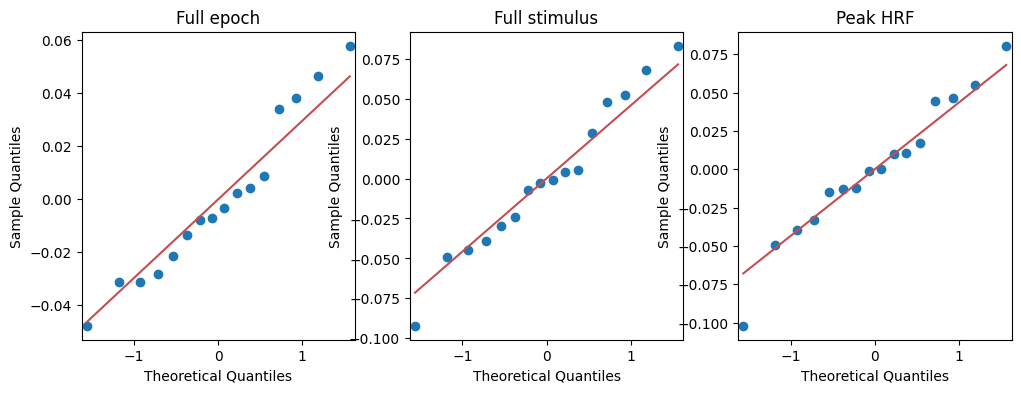

In [195]:
# Visual inspection of normality with QQ-plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
#fig.suptitle('Q-Q PLot')

sm.qqplot(full_epoch_model.resid, dist = norm, line = 's', ax = ax1)
ax1.set_title("Full epoch")

sm.qqplot(full_stimulus_model.resid, dist = norm, line = 's', ax = ax2)
ax2.set_title("Full stimulus")

sm.qqplot(HRF_epoch_model.resid, dist = norm, line = 's', ax = ax3)
ax3.set_title("Peak HRF")

plt.show()

In [197]:
# Perform Shapiro-Wilk test
alpha = 0.05

SH = []
for resid in [full_epoch_model.resid, full_stimulus_model.resid, HRF_epoch_model.resid]:
    SH.append([shapiro(resid)[0], shapiro(resid)[1]])
SH = pd.DataFrame(SH, columns = ['statistic', 'pvalue'])
SH['Significance'] = np.where(SH['pvalue'] < alpha, 'Not normally distributed', 'Normally distributed')
SH['Metric'] = ["Full epoch","Full stimulus", "Peak HRF"]
SH = SH[['Metric', 'statistic', 'pvalue', 'Significance']]
if export:
    dfi.export(SH,"Block_avg/SH_RQ1.png")
SH

Metric  statistic    pvalue          Significance
0     Full epoch   0.950150  0.492074  Normally distributed
1  Full stimulus   0.976761  0.932667  Normally distributed
2       Peak HRF   0.976166  0.925880  Normally distributed

In [200]:
# White’s Lagrange Multiplier Test for Heteroscedasticity
WLM = []
for tuple in [(full_epoch_model.resid, full_epoch_model.model.exog), (full_stimulus_model.resid, full_stimulus_model.model.exog), (HRF_epoch_model.resid, HRF_epoch_model.model.exog)]:
    WLM.append(list(het_white(tuple[0], tuple[1])))
WLM = pd.DataFrame(WLM, columns = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"])
WLM['Significance LM-test'] = np.where(WLM['LM-Test p-value'] < alpha, 'Homoscedastic', 'Heteroscedastic')
WLM['Significance F-test'] = np.where(WLM['F-Test p-value'] < alpha, 'Heteroscedastisticity in the residual errors', 'No heteroscedastisticity in the residual errors')
WLM['Metric'] = ["Full epoch","Full stimulus", "Peak HRF"]
WLM = WLM[['Metric', "LM Statistic", "LM-Test p-value", 'Significance LM-test', "F-Statistic", "F-Test p-value", 'Significance F-test']]
if export:
    dfi.export(WLM,"Block_avg/WLM_RQ1.png")
WLM

Metric  LM Statistic  LM-Test p-value Significance LM-test  \
0     Full epoch      0.131083         0.717312      Heteroscedastic   
1  Full stimulus      0.517879         0.471748      Heteroscedastic   
2       Peak HRF      1.512582         0.218746      Heteroscedastic   

   F-Statistic  F-Test p-value  \
0     0.115645        0.738855   
1     0.468302        0.504940   
2     1.461692        0.246684   

                               Significance F-test  
0  No heteroscedastisticity in the residual errors  
1  No heteroscedastisticity in the residual errors  
2  No heteroscedastisticity in the residual errors

---
*LM test:* P-values are high. So we accept the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

*F-test:* P-values confirm the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

---

##### Research question 2:  Comparison of left and right hemisphere

###### Left hand grasping vs Right hand rasping

In [201]:
# Encode the ROIs as ipsi- or contralateral to the hand that is tapping.
df["Hemisphere"] = "Unknown"
df.loc[(df["Condition"] == "test/RIGHT") &
       (df["ROI"] == "Right_ROI"), "Hemisphere"] = "Ipsilateral"
df.loc[(df["Condition"] == "test/RIGHT") &
       (df["ROI"] == "Left_ROI"), "Hemisphere"] = "Contralateral"
df.loc[(df["Condition"] == "test/LEFT") &
       (df["ROI"] == "Left_ROI"), "Hemisphere"] = "Ipsilateral"
df.loc[(df["Condition"] == "test/LEFT") &
       (df["ROI"] == "Right_ROI"), "Hemisphere"] = "Contralateral"

# Subset the data for example model
input_data = df.query("Condition in ['test/RIGHT', 'test/LEFT']")
input_data = input_data.query("Chroma in ['hbo']")
assert len(input_data)

input_data

ID        ROI Chroma   Condition  Mean_epoch  Mean_task  Mean_HRF  \
16  1   Left_ROI    hbo   test/LEFT   -0.040576  -0.050104 -0.049547   
18  1  Right_ROI    hbo   test/LEFT    0.016182   0.055234  0.095551   
20  2   Left_ROI    hbo   test/LEFT   -0.017363  -0.049687 -0.066388   
22  2  Right_ROI    hbo   test/LEFT    0.014653   0.023245  0.016611   
24  3   Left_ROI    hbo   test/LEFT    0.007131   0.028555  0.044806   
26  3  Right_ROI    hbo   test/LEFT    0.023268   0.050981  0.059983   
28  4   Left_ROI    hbo   test/LEFT    0.071409   0.116484  0.129536   
30  4  Right_ROI    hbo   test/LEFT    0.102706   0.160099  0.174759   
32  1   Left_ROI    hbo  test/RIGHT    0.078408   0.130187  0.118899   
34  1  Right_ROI    hbo  test/RIGHT    0.042586   0.047080 -0.002463   
36  2   Left_ROI    hbo  test/RIGHT   -0.024354  -0.040568 -0.042519   
38  2  Right_ROI    hbo  test/RIGHT   -0.017719  -0.019057 -0.000694   
40  3   Left_ROI    hbo  test/RIGHT    0.032511   0.063450  0.070130   
42  3  Right_ROI    hbo  test/RIGHT    0.023914   0.053724  0.056370   
44  4   Left_ROI    hbo  test/RIGHT    0.050209   0.082346  0.075649   
46  4  Right_ROI    hbo  test/RIGHT    0.066772   0.100212  0.081589   

       Hemisphere  
16    Ipsilateral  
18  Contralateral  
20    Ipsilateral  
22  Contralateral  
24    Ipsilateral  
26  Contralateral  
28    Ipsilateral  
30  Contralateral  
32  Contralateral  
34    Ipsilateral  
36  Contralateral  
38    Ipsilateral  
40  Contralateral  
42    Ipsilateral  
44  Contralateral  
46    Ipsilateral

In [202]:
# Mean over full epoch
full_epoch_model = smf.mixedlm("Mean_epoch ~ Hemisphere", input_data,
                        groups=input_data["ID"]).fit()
full_epoch_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM     Dependent Variable:     Mean_epoch
No. Observations:     16          Method:                 REML      
No. Groups:           4           Scale:                  0.0008    
Min. group size:      4           Log-Likelihood:         25.3578   
Max. group size:      4           Converged:              Yes       
Mean group size:      4.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.037    0.019  1.966 0.049  0.000  0.073
Hemisphere[T.Ipsilateral] -0.020    0.014 -1.400 0.161 -0.047  0.008
Group Var                  0.001    0.039                           
====================================================================

"""

In [203]:
# Mean over stimulus duration
full_stimulus_model = smf.mixedlm("Mean_task ~ Hemisphere", input_data,
                        groups=input_data["ID"]).fit()
full_stimulus_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM     Dependent Variable:     Mean_task
No. Observations:      16          Method:                 REML     
No. Groups:            4           Scale:                  0.0016   
Min. group size:       4           Log-Likelihood:         19.9228  
Max. group size:       4           Converged:              Yes      
Mean group size:       4.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.066    0.030  2.216 0.027  0.008  0.124
Hemisphere[T.Ipsilateral] -0.037    0.020 -1.840 0.066 -0.077  0.002
Group Var                  0.003    0.071                           
====================================================================

"""

In [204]:
# Mean over HRF
HRF_epoch_model = smf.mixedlm("Mean_HRF ~ Hemisphere", input_data,
                        groups=input_data["ID"]).fit()
HRF_epoch_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                  MixedLM     Dependent Variable:     Mean_HRF
No. Observations:       16          Method:                 REML    
No. Groups:             4           Scale:                  0.0019  
Min. group size:        4           Log-Likelihood:         18.8978 
Max. group size:        4           Converged:              Yes     
Mean group size:        4.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.071    0.031  2.326 0.020  0.011  0.131
Hemisphere[T.Ipsilateral] -0.047    0.022 -2.130 0.033 -0.090 -0.004
Group Var                  0.003    0.068                           
====================================================================

"""

In [209]:
if export:
    table1, table2 = HRF_epoch_model.summary().tables
    table1.columns = table1.iloc[0]
    table1 = table1.drop([0])
    dfi.export(table1,"Block_avg/RQ2_table1.png")
    dfi.export(table2,"Block_avg/RQ2_table2.png")

---
> *Remark:*
- For the mean amplitude of the HRF, we get a significant difference. The ipsilateral responses are 0.047 μMol smaller than those on the contralateral side to the hand that is grasping.
---

##### Check the assumptions

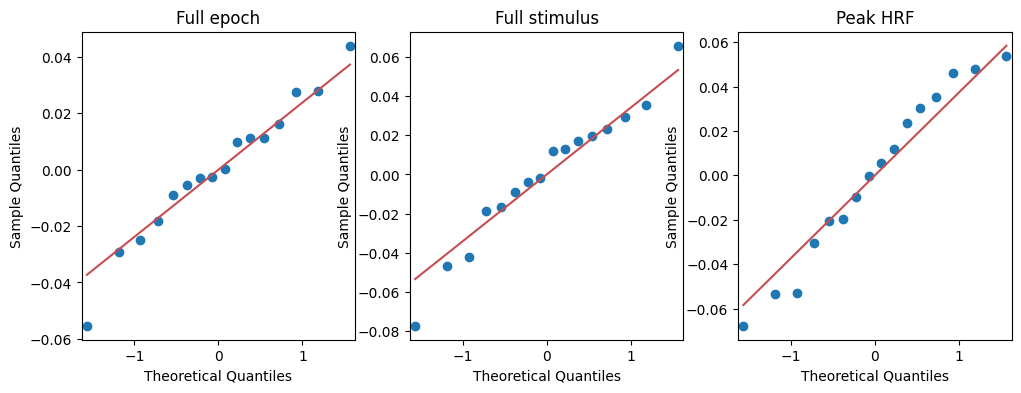

In [205]:
# Visual inspection of normality with QQ-plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
#fig.suptitle('Q-Q PLot')

sm.qqplot(full_epoch_model.resid, dist = norm, line = 's', ax = ax1)
ax1.set_title("Full epoch")

sm.qqplot(full_stimulus_model.resid, dist = norm, line = 's', ax = ax2)
ax2.set_title("Full stimulus")

sm.qqplot(HRF_epoch_model.resid, dist = norm, line = 's', ax = ax3)
ax3.set_title("Peak HRF")

plt.show()

In [207]:
# Perform Shapiro-Wilk test
alpha = 0.05

SH = []
for resid in [full_epoch_model.resid, full_stimulus_model.resid, HRF_epoch_model.resid]:
    SH.append([shapiro(resid)[0], shapiro(resid)[1]])
SH = pd.DataFrame(SH, columns = ['statistic', 'pvalue'])
SH['Significance'] = np.where(SH['pvalue'] < alpha, 'Not normally distributed', 'Normally distributed')
SH['Metric'] = ["Full epoch","Full stimulus", "Peak HRF"]
SH = SH[['Metric', 'statistic', 'pvalue', 'Significance']]
if export:
    dfi.export(SH,"Block_avg/SH_RQ2.png")
SH

Metric  statistic    pvalue          Significance
0     Full epoch   0.980257  0.965602  Normally distributed
1  Full stimulus   0.973542  0.892197  Normally distributed
2       Peak HRF   0.950830  0.502954  Normally distributed

In [208]:
# White’s Lagrange Multiplier Test for Heteroscedasticity
WLM = []
for tuple in [(full_epoch_model.resid, full_epoch_model.model.exog), (full_stimulus_model.resid, full_stimulus_model.model.exog), (HRF_epoch_model.resid, HRF_epoch_model.model.exog)]:
    WLM.append(list(het_white(tuple[0], tuple[1])))
WLM = pd.DataFrame(WLM, columns = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"])
WLM['Significance LM-test'] = np.where(WLM['LM-Test p-value'] < alpha, 'Homoscedastic', 'Heteroscedastic')
WLM['Significance F-test'] = np.where(WLM['F-Test p-value'] < alpha, 'Heteroscedastisticity in the residual errors', 'No heteroscedastisticity in the residual errors')
WLM['Metric'] = ["Full epoch","Full stimulus", "Peak HRF"]
WLM = WLM[['Metric', "LM Statistic", "LM-Test p-value", 'Significance LM-test', "F-Statistic", "F-Test p-value", 'Significance F-test']]
if export:
    dfi.export(WLM,"Block_avg/WLM_RQ2.png")
WLM

Metric  LM Statistic  LM-Test p-value Significance LM-test  \
0     Full epoch      0.007879         0.929269      Heteroscedastic   
1  Full stimulus      0.072774         0.787340      Heteroscedastic   
2       Peak HRF      0.135883         0.712409      Heteroscedastic   

   F-Statistic  F-Test p-value  \
0     0.006898        0.934986   
1     0.063968        0.804007   
2     0.119916        0.734275   

                               Significance F-test  
0  No heteroscedastisticity in the residual errors  
1  No heteroscedastisticity in the residual errors  
2  No heteroscedastisticity in the residual errors

---
*LM test:* P-values are high. So we accept the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

*F-test:* P-values confirm the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

---